# Installations

In [1]:
!pip install pulp
!apt-get install -y -qq glpk-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 38.3 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpackin

# Model 1: Pulp Model
Capacitated VRP with vehicle capacities, MIP technique

In [2]:
#Importing Libraries
import numpy as np
import pandas as pd
import pulp
import itertools
import math

In [8]:
#Input data
# customer count ('0' is depot)
customer_count = 14
vehicle_count = 2
vehicle_capacity = 14

#Generating random customer locations
# fix random seed
np.random.seed(seed=777)
# set depot latitude and longitude
depot_latitude = 40.748817
depot_longitude = -73.985428
# make dataframe which contains vending machine location and demand                         #syntax: np.random.normal(mean, standard deviation, shape)
df = pd.DataFrame({"latitude":np.random.normal(depot_latitude, 0.007, customer_count),
                   "longitude":np.random.normal(depot_longitude, 0.007, customer_count),
                   "demand":np.random.randint(1, 5, customer_count)})
# set the depot as the center and make demand 0 ('0' = depot)
df.iloc[0,0] = depot_latitude
df.iloc[0,1] = depot_longitude
df.iloc[0,2] = 0
print(df)

     latitude  longitude  demand
0   40.748817 -73.985428       0
1   40.743057 -73.989340       1
2   40.748359 -73.994061       4
3   40.743823 -73.988505       3
4   40.755161 -73.979024       1
5   40.754181 -73.983573       3
6   40.754599 -73.995112       3
7   40.739551 -73.980629       1
8   40.736550 -73.982235       1
9   40.755834 -73.988658       2
10  40.752631 -73.984765       1
11  40.762083 -73.996228       2
12  40.743431 -73.968072       1
13  40.738995 -73.982230       2


In [9]:
sum(df.demand)

25

In [10]:
# function for calculating distance between two pins
def _distance_calculator(_df):
    _distance_result = np.zeros((len(_df),len(_df)))
    #print(_distance_result)
    for i in range(len(_df)):
        p = [_df.iloc[i].latitude,_df.iloc[i].longitude]
        for j in range(len(_df)):
            q = [_df.iloc[j].latitude,_df.iloc[j].longitude]
            dist = math.dist(p, q)
            _distance_result[i][j] = round(dist,3)
    return _distance_result

distance = _distance_calculator(df)
print(distance)

[[0.    0.007 0.009 0.006 0.009 0.006 0.011 0.01  0.013 0.008 0.004 0.017
  0.018 0.01 ]
 [0.007 0.    0.007 0.001 0.016 0.013 0.013 0.009 0.01  0.013 0.011 0.02
  0.021 0.008]
 [0.009 0.007 0.    0.007 0.017 0.012 0.006 0.016 0.017 0.009 0.01  0.014
  0.026 0.015]
 [0.006 0.001 0.007 0.    0.015 0.011 0.013 0.009 0.01  0.012 0.01  0.02
  0.02  0.008]
 [0.009 0.016 0.017 0.015 0.    0.005 0.016 0.016 0.019 0.01  0.006 0.019
  0.016 0.016]
 [0.006 0.013 0.012 0.011 0.005 0.    0.012 0.015 0.018 0.005 0.002 0.015
  0.019 0.015]
 [0.011 0.013 0.006 0.013 0.016 0.012 0.    0.021 0.022 0.007 0.011 0.008
  0.029 0.02 ]
 [0.01  0.009 0.016 0.009 0.016 0.015 0.021 0.    0.003 0.018 0.014 0.027
  0.013 0.002]
 [0.013 0.01  0.017 0.01  0.019 0.018 0.022 0.003 0.    0.02  0.016 0.029
  0.016 0.002]
 [0.008 0.013 0.009 0.012 0.01  0.005 0.007 0.018 0.02  0.    0.005 0.01
  0.024 0.018]
 [0.004 0.011 0.01  0.01  0.006 0.002 0.011 0.014 0.016 0.005 0.    0.015
  0.019 0.014]
 [0.017 0.02  0.014 0.02

In [11]:
# solve with pulp - capacitated vehicle routing problem with no compulsion on all vehicles to be used
for vehicle_count in range(1,vehicle_count+1):

    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1 = CONSTRAINT 7
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]
    #print(x)

    # add objective function = CONSTRAINT 1
    problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count)
                          for j in range(customer_count)
                          for i in range (customer_count))
    #print(problem)

    # constraints
    # foluma (2) = CONSTRAINT2
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0
                              for i in range(customer_count)
                              for k in range(vehicle_count)) == 1

    # foluma (3) = CONSTRAINT 3
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1
        #if we omit this constraint can we make it OVRP?

    # foluma (4) = CONSTRAINT 4
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #foluma (5) = CONSTRAINT 5
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity

    # fomula (6) = CONSTRAINT 6
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i) #syntax i in number of entities in the combination
    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    # print vehicle_count which needed for solving problem
    # print calculated minimum distance value
    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break

Vehicle Requirements: 2
Moving Distance: 0.101


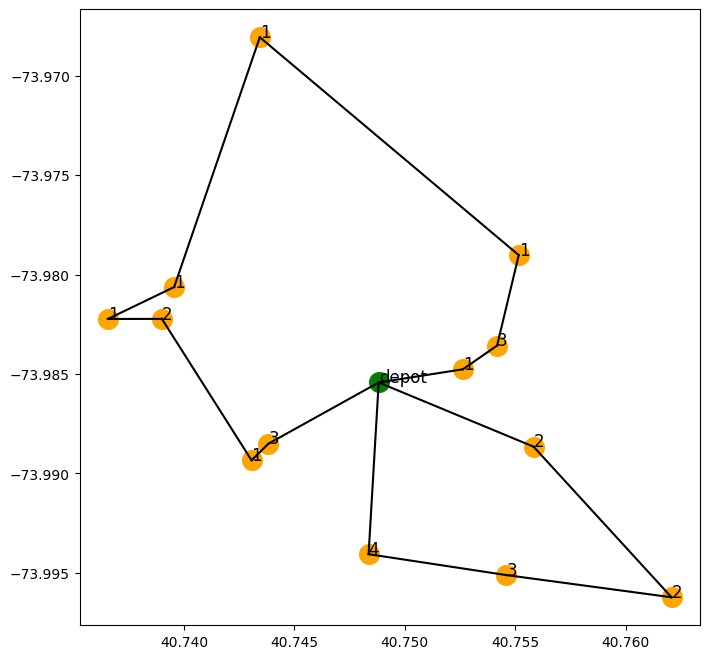

In [12]:
import matplotlib.pyplot as plt

# visualization : plotting with matplolib
plt.figure(figsize=(8,8))
for i in range(customer_count):
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
        plt.text(df.latitude[i], df.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
        plt.text(df.latitude[i], df.longitude[i], str(df.demand[i]), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black") #syntax = plt.plot([x1,x2],[y1,y2])

plt.show()

#Tabu Search Algorithm

## Trial 1

In [ ]:
import random

# Define the objective function
def objective_function(solution):
  print(sum(solution))
  return sum(solution)

# Define the neighborhood function
def get_neighbors(solution):
  neighbors = []
  for i in range(len(solution)):
    for j in range(i + 1, len(solution)):
      neighbor = solution[:]
      neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
      neighbors.append(neighbor)
  print(neighbors)
  return neighbors

# Define the Tabu Search algorithm
def tabu_search(initial_solution, max_iterations, tabu_list_size):
	best_solution = initial_solution
	current_solution = initial_solution
	tabu_list = []

	for _ in range(max_iterations):
		neighbors = get_neighbors(current_solution)
		best_neighbor = None
		best_neighbor_fitness = float('inf')

		for neighbor in neighbors:
			if neighbor not in tabu_list:
				neighbor_fitness = objective_function(neighbor)
				if neighbor_fitness < best_neighbor_fitness:
					best_neighbor = neighbor
					best_neighbor_fitness = neighbor_fitness

		if best_neighbor is None:
			break

		current_solution = best_neighbor
		tabu_list.append(best_neighbor)
		if len(tabu_list) > tabu_list_size:
			tabu_list.pop(0)

		if objective_function(best_neighbor) < objective_function(best_solution):
			best_solution = best_neighbor

	return best_solution

# Example usage
initial_solution = [1, 2, 3, 4, 5]
max_iterations = 10
tabu_list_size = 10

best_solution = tabu_search(initial_solution, max_iterations, tabu_list_size)
print("Best solution: {}".format(best_solution))
print("Best solution fitness: {}".format(objective_function(best_solution)))

[[2, 1, 3, 4, 5], [3, 2, 1, 4, 5], [4, 2, 3, 1, 5], [5, 2, 3, 4, 1], [1, 3, 2, 4, 5], [1, 4, 3, 2, 5], [1, 5, 3, 4, 2], [1, 2, 4, 3, 5], [1, 2, 5, 4, 3], [1, 2, 3, 5, 4]]
15
15
15
15
15
15
15
15
15
15
15
15
[[1, 2, 3, 4, 5], [3, 1, 2, 4, 5], [4, 1, 3, 2, 5], [5, 1, 3, 4, 2], [2, 3, 1, 4, 5], [2, 4, 3, 1, 5], [2, 5, 3, 4, 1], [2, 1, 4, 3, 5], [2, 1, 5, 4, 3], [2, 1, 3, 5, 4]]
15
15
15
15
15
15
15
15
15
15
15
15
[[2, 1, 3, 4, 5], [3, 2, 1, 4, 5], [4, 2, 3, 1, 5], [5, 2, 3, 4, 1], [1, 3, 2, 4, 5], [1, 4, 3, 2, 5], [1, 5, 3, 4, 2], [1, 2, 4, 3, 5], [1, 2, 5, 4, 3], [1, 2, 3, 5, 4]]
15
15
15
15
15
15
15
15
15
15
15
[[2, 3, 1, 4, 5], [1, 2, 3, 4, 5], [4, 2, 1, 3, 5], [5, 2, 1, 4, 3], [3, 1, 2, 4, 5], [3, 4, 1, 2, 5], [3, 5, 1, 4, 2], [3, 2, 4, 1, 5], [3, 2, 5, 4, 1], [3, 2, 1, 5, 4]]
15
15
15
15
15
15
15
15
15
15
15
[[3, 2, 1, 4, 5], [1, 3, 2, 4, 5], [4, 3, 1, 2, 5], [5, 3, 1, 4, 2], [2, 1, 3, 4, 5], [2, 4, 1, 3, 5], [2, 5, 1, 4, 3], [2, 3, 4, 1, 5], [2, 3, 5, 4, 1], [2, 3, 1, 5, 4]]
15
15
1

## Trial 2
Tabu search VRP: 2 vehicles
Works only for 2 vehicles

In [ ]:
import numpy as np
import random
import copy

# Define the distance matrix
distance_matrix = np.array([[0, 10, 15, 20, 45],
                            [10, 0, 35, 25, 34],
                            [15, 35, 0, 30, 25],
                            [20, 25, 30, 0, 10],
                            [45, 34, 25, 10, 0]])

# Define parameters
num_customers = distance_matrix.shape[0] - 1  # Number of customers (excluding the depot), shape[0] returns number of rows in the matrix
num_vehicles = 2  # Number of vehicles
vehicle_capacity = 100  # Capacity of each vehicle

In [ ]:
# Define initial solution (randomized)
def initial_solution():
    route = list(range(1, num_customers + 1))
    random.shuffle(route)
    #print(route)
    routes = [route[:len(route)//2], route[len(route)//2:]] #2 becoz num_vehicles = 2
    #print(routes)
    return routes
print(initial_solution())

# Evaluate the total distance of a solution
def calculate_distance(solution):
    total_distance = 0
    for route in solution:
        if len(route) > 0:
            current_node = 0  # Start at the depot
            for customer in route:
                total_distance += distance_matrix[current_node][customer]
                current_node = customer
            total_distance += distance_matrix[current_node][0]  # Return to the depot
    return total_distance

[[1, 2], [3, 4]]


In [ ]:
# Tabu Search
def tabu_search(max_iterations):
    current_solution = initial_solution()
    best_solution = copy.deepcopy(current_solution) #deepcopy helps does not change current_solution when best_solution is changed
    tabu_list = []
    best_distance = calculate_distance(current_solution)

    for iteration in range(max_iterations):
        neighbors = []
        for i in range(num_customers):
            for j in range(i + 1, num_customers):
              #print(current_solution)
              neighbor = copy.deepcopy(current_solution)
              #print(neighbor)
              if ((j-i-1) < len(neighbor[1])):
                neighbor[0].insert(i, neighbor[1].pop(j-i-1))
                neighbors.append(neighbor)
                #print(neighbors)

        # Evaluate neighbors and choose the best one
        best_neighbor = None
        best_neighbor_distance = float('inf')
        for neighbor in neighbors:
            neighbor_distance = calculate_distance(neighbor)
            if neighbor_distance < best_neighbor_distance and neighbor not in tabu_list:
                best_neighbor = neighbor
                best_neighbor_distance = neighbor_distance

        # Update current solution
        current_solution = best_neighbor

        # Update best solution if needed
        if best_neighbor_distance < best_distance:
            best_solution = best_neighbor
            best_distance = best_neighbor_distance

        # Add current solution to the tabu list
        tabu_list.append(current_solution)
        if len(tabu_list) > 10:
            tabu_list.pop(0)

        print(f"Iteration {iteration + 1}/{max_iterations}: Best Distance = {best_distance}")

    return best_solution, best_distance

# # Main
best_solution, best_distance = tabu_search(max_iterations=3)

print("\nBest Solution:")
for i, route in enumerate(best_solution):
    print(f"Route {i + 1}: {route}")
print(f"Best Distance: {best_distance}")

Iteration 1/3: Best Distance = 104
Iteration 2/3: Best Distance = 99
Iteration 3/3: Best Distance = 99

Best Solution:
Route 1: [2, 3, 4, 1]
Route 2: []
Best Distance: 99


## Model 2.1: 10 vehicles, 20 customers

In [ ]:
import pandas as pd
import numpy as np
import random
import copy

# Define problem parameters
num_nodes = 10
num_vehicles = 3
vehicle_capacity = 50
depot = (0,0)
df = pd.DataFrame({"latitude":np.random.uniform(-10, 10, num_nodes),
                   "longitude":np.random.uniform(-10, 10, num_nodes),
                   "demand":np.random.randint(10, 20, num_nodes)})
node_locations = [(lat, lon) for lat, lon in zip(df['latitude'], df['longitude'])]
node_demands = [dem for dem in df['demand']]

In [ ]:
#df.head()
df

,latitude,longitude,demand
0,7.271768,-6.105277,14
1,0.442407,-8.628549,13
2,9.152145,6.190730,10
3,3.672598,3.943515,17
4,9.553660,8.210098,12
5,-7.328233,-4.465754,13
6,4.191724,7.782650,19
7,-4.018731,0.854381,16
8,-1.386502,7.869055,16
9,-9.042995,4.072863,17


In [ ]:
# Calculate the distance between two points (Euclidean distance)
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

def initial_solution():
    unvisited_customers = list(range(0, num_nodes))
    routes = [[] for _ in range(num_vehicles)]

    for v in range(num_vehicles):
        capacity = vehicle_capacity
        current_location = (0, 0)
        while unvisited_customers:
            #print(unvisited_customers)
            nearest_customer = min(unvisited_customers, key=lambda c: distance(current_location, customer_locations[c])) #c iterates over the customer indices in the unvisited_customers list.
            #print("nearest cus: ",nearest_customer)
            if capacity >= customer_demands[nearest_customer]:
                routes[v].append(nearest_customer)
                capacity -= customer_demands[nearest_customer]
                current_location = customer_locations[nearest_customer]
                unvisited_customers.remove(nearest_customer)
            else:
                break  # Vehicle capacity exceeded, start a new route
    #print(routes)
    print("Initial Solution:", routes)
    return routes

# Calculate the total distance of a solution
def calculate_total_distance(solution):
    total_distance = 0
    depot = (0, 0)  # Depot is assumed to be at (0, 0)
    for route in solution:
        current_location = depot
        for customer in route:
            total_distance += distance(current_location, customer_locations[customer])
            current_location = customer_locations[customer]
        total_distance += distance(current_location, depot)
    return total_distance

# Define Tabu Search parameters
num_iterations = 100
tabu_list_size = 5

# Initialize the current solution
current_solution = initial_solution()
current_distance = calculate_total_distance(current_solution)

# Initialize Tabu List
tabu_list = []
best_solution = None
best_distance = float('inf')

# Main Tabu Search loop
for iteration in range(num_iterations):
    best_neighbor_solution = None
    best_neighbor_distance = float('inf')

    for v in range(num_vehicles):
        for i in range(len(current_solution[v])):
            for j in range(i + 1, len(current_solution[v])):
                #print("in")
                neighbor_solution = copy.deepcopy(current_solution)
                neighbor_solution[v][i], neighbor_solution[v][j] = neighbor_solution[v][j], neighbor_solution[v][i]
                neighbor_distance = calculate_total_distance(neighbor_solution)
                print(neighbor_distance)
                print(neighbor_solution)
                if neighbor_distance < best_neighbor_distance and neighbor_solution not in tabu_list:
                    best_neighbor_solution = neighbor_solution
                    best_neighbor_distance = neighbor_distance

    if best_neighbor_solution is None:
        break

    current_solution = best_neighbor_solution
    current_distance = best_neighbor_distance
    #print("current_solution",current_solution)
    #print("current_distance",current_distance)

    # Update Tabu List
    tabu_list.append(current_solution)
    #print(tabu_list)
    if len(tabu_list) > tabu_list_size:
        tabu_list.pop(0)

    # Compare with the current best solution
    if current_distance < best_distance:
        best_solution = current_solution
        best_distance = current_distance


# Print the best solution found
print("Best Solution:", best_solution)
print("Total Distance:", best_distance)

Initial Solution: [[8, 6, 3], [7, 9, 4], [0, 2, 5]]
93.41664405677055
[[6, 8, 3], [7, 9, 4], [0, 2, 5]]
85.23542814877482
[[3, 6, 8], [7, 9, 4], [0, 2, 5]]
85.24536015183499
[[8, 3, 6], [7, 9, 4], [0, 2, 5]]
86.21458964131557
[[8, 6, 3], [9, 7, 4], [0, 2, 5]]
85.23542814877482
[[8, 6, 3], [4, 9, 7], [0, 2, 5]]
96.4798898423478
[[8, 6, 3], [7, 4, 9], [0, 2, 5]]
89.52209793179732
[[8, 6, 3], [7, 9, 4], [2, 0, 5]]
85.23542814877482
[[8, 6, 3], [7, 9, 4], [5, 2, 0]]
92.25279804758091
[[8, 6, 3], [7, 9, 4], [0, 5, 2]]
85.24536015183499
[[6, 3, 8], [7, 9, 4], [0, 2, 5]]
85.23542814877482
[[8, 6, 3], [7, 9, 4], [0, 2, 5]]
93.41664405677055
[[3, 8, 6], [7, 9, 4], [0, 2, 5]]
86.21458964131557
[[3, 6, 8], [9, 7, 4], [0, 2, 5]]
85.23542814877482
[[3, 6, 8], [4, 9, 7], [0, 2, 5]]
96.4798898423478
[[3, 6, 8], [7, 4, 9], [0, 2, 5]]
89.52209793179732
[[3, 6, 8], [7, 9, 4], [2, 0, 5]]
85.23542814877482
[[3, 6, 8], [7, 9, 4], [5, 2, 0]]
92.25279804758091
[[3, 6, 8], [7, 9, 4], [0, 5, 2]]
93.41664405677

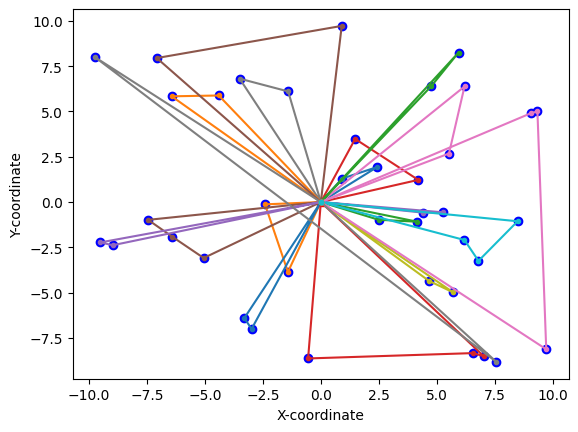

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_routes(routes, customer_locations):
    depot = (0, 0)
    plt.scatter(*depot, marker='s', color='red', label='Depot')
    # Plot customer locations
    for i, loc in enumerate(customer_locations):
        plt.scatter(*loc, marker='o', color='blue', label=f'Customer {i + 1}')
    # Plot routes
    for r, route in enumerate(routes):
        route_points = [depot]  # Start from depot
        for customer in route:
            route_points.append(customer_locations[customer])
        route_points.append(depot)  # Return to depot
        route_x, route_y = zip(*route_points)
        plt.plot(route_x, route_y, marker='.', label=f'Route {r + 1}', linestyle='-')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.legend()
    #plt.figure(figsize=(8, 8))
    plt.show()

plot_routes(best_solution, customer_locations)

## Model 2.1: For Employee data

In [ ]:
import pandas as pd
import numpy as np
import random
import copy
import math

In [ ]:
df = pd.read_csv('data.csv')
df.head()

,Boarding Points,Latitude,Longitude,Demand
0,Avadi Bs,13.113559,80.086088,16
1,Avadi check post,13.101313,80.084063,17
2,Ponnu super market,13.115993,80.100314,7
3,J.P.Estate,13.114225,80.093337,19
4,Paruthipattu,13.091407,80.104143,12


In [ ]:
# Define problem parameters
num_customers = len(df)
num_vehicles = 45
vehicle_capacity = 46
depot = (12.95, 80.01)

customer_locations = [(lat, lon) for lat, lon in zip(df['Latitude'], df['Longitude'])]
customer_demands = [dem for dem in df['Demand']]

In [ ]:
# Calculate the distance between two points (Euclidean distance)

def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    ans = (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)*111/math.cos((x1+x2)/2)
    return ans

# def initial_solution():
#     unvisited_customers = list(range(0, num_customers))
#     routes = [[] for _ in range(num_vehicles)]

#     for v in range(num_vehicles):
#         capacity = vehicle_capacity
#         current_location = (12.95, 80.01)
#         while unvisited_customers:
#             nearest_customer = min(unvisited_customers, key=lambda c: distance(current_location, customer_locations[c])) #c iterates over the customer indices in the unvisited_customers list.
#             if capacity >= customer_demands[nearest_customer]:
#                 routes[v].append(nearest_customer)
#                 capacity -= customer_demands[nearest_customer]
#                 current_location = customer_locations[nearest_customer]
#                 unvisited_customers.remove(nearest_customer)
#             else:
#                 break  # Vehicle capacity exceeded, start a new route
#     print(routes)
#     return routes

def nearest_neighbor_heuristic():
    unvisited_customers = list(range(0, num_customers))
    routes = [[] for _ in range(num_vehicles)]
    for v in range(num_vehicles):
        capacity = vehicle_capacity
        current_location = (12.95, 80.01)
        while unvisited_customers:
            nearest_customer = min(unvisited_customers, key=lambda c: distance(current_location, customer_locations[c])) #c iterates over the customer indices in the unvisited_customers list.
            if capacity >= customer_demands[nearest_customer]:
                routes[v].append(nearest_customer)
                capacity -= customer_demands[nearest_customer]
                current_location = customer_locations[nearest_customer]
                unvisited_customers.remove(nearest_customer)
            else:
                break  # Vehicle capacity exceeded, start a new route
    print("Initial Solution :", routes)
    return routes

#initial_solution()
# Calculate the total distance of a solution
def calculate_total_distance(solution):
    total_distance = 0
    depot = (12.95, 80.01)
    for route in solution:
        current_location = depot
        route_distance = 0
        for customer in route:
            route_distance += distance(current_location, customer_locations[customer])
            current_location = customer_locations[customer]
        route_distance += distance(current_location, depot)
        total_distance += route_distance
    return total_distance

# Define Tabu Search parameters
num_iterations = 500
tabu_list_size = 5

# Initialize the current solution
#current_solution = initial_solution()
current_solution = nearest_neighbor_heuristic()
current_distance = calculate_total_distance(current_solution)

# Initialize Tabu List
tabu_list = []

best_solution = None
best_distance = float('inf')

# Main Tabu Search loop
for iteration in range(num_iterations):
    best_neighbor_solution = None
    best_neighbor_distance = float('inf')

    for v in range(num_vehicles):
        for i in range(len(current_solution[v])):
            for j in range(i + 1, len(current_solution[v])):
                #print("in")
                neighbor_solution = copy.deepcopy(current_solution)
                neighbor_solution[v][i], neighbor_solution[v][j] = neighbor_solution[v][j], neighbor_solution[v][i]
                neighbor_distance = calculate_total_distance(neighbor_solution)
                #print(neighbor_distance)
                #print(neighbor_solution)
                if neighbor_distance < best_neighbor_distance and neighbor_solution not in tabu_list:
                    best_neighbor_solution = neighbor_solution
                    best_neighbor_distance = neighbor_distance
                    current_solution = neighbor_solution

    if best_neighbor_solution is None:
        break

    current_solution = best_neighbor_solution
    current_distance = best_neighbor_distance
    #print("current_solution",current_solution)
    #print("current_distance",current_distance)

    # Update Tabu List
    tabu_list.append(current_solution)
    #print(tabu_list)
    if len(tabu_list) > tabu_list_size:
        tabu_list.pop(0)

    # Compare with the current best solution
    if current_distance < best_distance:
        best_solution = current_solution
        best_distance = current_distance


# Print the best solution found
print("Best Solution:", best_solution)
print("Total Distance:", best_distance)

Initial Solution : [[43, 42, 44, 36, 40, 32], [115, 58, 59], [14, 15], [18, 16, 127], [17, 27, 26], [114, 54, 55, 111, 34], [37, 60, 57, 56], [41, 39], [130, 25, 24], [53, 52, 51, 50], [113, 33], [13, 12, 10], [31, 35, 112], [28, 126], [73, 72, 129], [30, 29, 38], [9, 8, 7], [11, 6], [125, 124, 71], [96, 97, 95], [110, 109], [5, 4], [94, 81, 86, 78], [1, 0], [108, 107, 106, 105], [49, 98, 135], [23, 21, 22], [70, 69, 128], [3, 2, 92], [79, 80, 99], [48, 47, 45, 46], [91, 93, 77], [20, 19, 90], [76, 75, 74], [104, 103, 102, 101], [100, 132, 131], [68, 67, 66], [89, 88, 87], [123, 62, 63, 64], [65, 61, 122], [82, 83, 133], [84, 85, 121], [120, 119, 118], [134, 117, 116], []]
Best Solution: [[43, 44, 42, 36, 40, 32], [115, 58, 59], [14, 15], [18, 16, 127], [17, 27, 26], [114, 54, 55, 111, 34], [37, 60, 57, 56], [41, 39], [130, 25, 24], [53, 52, 51, 50], [113, 33], [13, 12, 10], [31, 35, 112], [126, 28], [73, 129, 72], [30, 29, 38], [9, 7, 8], [11, 6], [125, 124, 71], [96, 97, 95], [110, 1

In [ ]:
route_demands_1 = []
for route in best_solution:
  route_demand_1 = 0
  for node in route:
    #print(node)
    route_demand_1 += customer_demands[node]
  route_demands_1.append(route_demand_1)

route_demand_dict_1 = dict(zip(range(len(best_solution)), route_demands_1))

print("Route Demands:", route_demand_dict_1)

Route Demands: {0: 41, 1: 42, 2: 40, 3: 34, 4: 43, 5: 44, 6: 46, 7: 38, 8: 45, 9: 42, 10: 35, 11: 30, 12: 46, 13: 34, 14: 37, 15: 39, 16: 45, 17: 35, 18: 39, 19: 36, 20: 31, 21: 30, 22: 40, 23: 33, 24: 44, 25: 42, 26: 38, 27: 45, 28: 42, 29: 41, 30: 41, 31: 41, 32: 36, 33: 37, 34: 34, 35: 33, 36: 35, 37: 43, 38: 44, 39: 29, 40: 42, 41: 43, 42: 36, 43: 43, 44: 0}


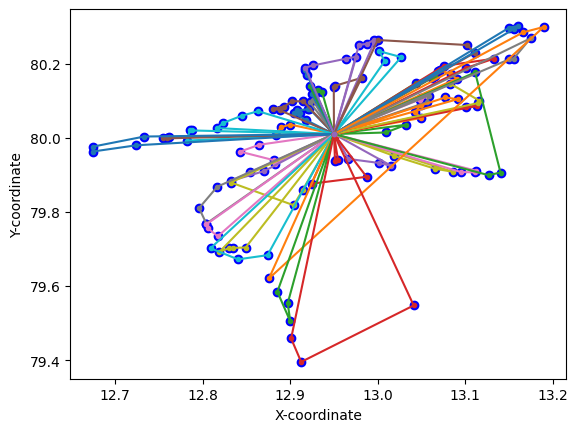

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_routes(routes, customer_locations):
    depot = (12.95, 80.01)
    plt.scatter(*depot, marker='s', color='red', label='Depot')
    # Plot customer locations
    for i, loc in enumerate(customer_locations):
        plt.scatter(*loc, marker='o', color='blue', label=f'Customer {i + 1}')
    # Plot routes
    for r, route in enumerate(routes):
        route_points = [depot]  # Start from depot
        for customer in route:
            route_points.append(customer_locations[customer])
        route_points.append(depot)  # Return to depot
        route_x, route_y = zip(*route_points)
        plt.plot(route_x, route_y, marker='.', label=f'Route {r + 1}', linestyle='-')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.legend()
    #plt.figure(figsize=(8, 8))
    plt.show()

plot_routes(best_solution, customer_locations)

## Model 2.2: Final Tabu Search

In [ ]:
import pandas as pd
import numpy as np
import random
import copy
import math

In [ ]:
df = pd.read_csv('data.csv')
df.head()

,Boarding Points,Latitude,Longitude,Demand
0,Avadi Bs,13.113559,80.086088,16
1,Avadi check post,13.101313,80.084063,17
2,Ponnu super market,13.115993,80.100314,7
3,J.P.Estate,13.114225,80.093337,19
4,Paruthipattu,13.091407,80.104143,12


In [ ]:
# Define problem parameters
num_nodes = len(df)
num_vehicles = 45
vehicle_capacity = 46
depot = (12.95, 80.01)
#depot = (22, 40)

node_locations = [(lat, lon) for lat, lon in zip(df['Latitude'], df['Longitude'])]
node_demands = [dem for dem in df['Demand']]

In [ ]:
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    ans = (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)*111/math.cos((x1+x2)/2)
    return abs(ans)

def nearest_neighbor_heuristic():
    unvisited_customers = list(range(0, num_nodes))
    routes = [[] for _ in range(num_vehicles)]
    for v in range(num_vehicles):
        capacity = vehicle_capacity
        current_location = (12.95, 80.01)
        while unvisited_customers:
            nearest_customer = min(unvisited_customers, key=lambda c: distance(current_location, node_locations[c])) #c iterates over the customer indices in the unvisited_customers list.
            if capacity >= node_demands[nearest_customer]:
                routes[v].append(nearest_customer)
                capacity -= node_demands[nearest_customer]
                current_location = node_locations[nearest_customer]
                unvisited_customers.remove(nearest_customer)
            else:
                break  # Vehicle capacity exceeded, start a new route
    print("Initial Solution :", routes)
    return routes

def evaluate_solution(solution, penalty_coefficient):
    total_distance = 0
    total_penalty = 0
    for route in solution:
        current_location = depot
        route_distance = 0
        route_demand = 0
        for customer in route:
            route_distance += distance(current_location, node_locations[customer])
            current_location = node_locations[customer]
            route_demand += node_demands[customer]
            if route_demand > vehicle_capacity:
                excess_load = route_demand - vehicle_capacity
                total_penalty += excess_load * penalty_coefficient
        route_distance += distance(current_location, depot)
        total_distance += route_distance
    return total_distance + total_penalty
    #return total_distance

In [ ]:
#vertex reassignment: 1st selected vertex is removed from position and added in position before the 2nd selected vertex
def apply_vertex_reassignment(current_solution, vertex1, vertex2): #both
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
      if vertex1 in route:
        route1 = route
      if vertex2 in route:
        route2 = route
    index_vertex1 = route1.index(vertex1)
    index_vertex2 = route2.index(vertex2)
    route1.remove(vertex1)
    if route1 == route2:
      if index_vertex1 < index_vertex2:
        route2.insert(index_vertex2-1, vertex1)
      else:
        route2.insert(index_vertex2, vertex1)
    else:
        route2.insert(index_vertex2, vertex1)
    return new_solution

#vertex swap: postions of 2 selected vertices are swapped
def apply_vertex_swap(current_solution, vertex1, vertex2): #both
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
      if vertex1 in route:
        route1 = route
      if vertex2 in route:
        route2 = route
    index_vertex1 = route1.index(vertex1)
    index_vertex2 = route2.index(vertex2)
    route1[index_vertex1], route2[index_vertex2] = route2[index_vertex2], route1[index_vertex1]
    return new_solution

# 2-opt: all elements between two selected vertices are interchanged
def apply_2_opt(current_solution, vertex1, vertex2): #within a selected route
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
        if vertex1 in route and vertex2 in route:
            index_vertex1 = route.index(vertex1)
            index_vertex2 = route.index(vertex2)
            if index_vertex1 < index_vertex2:
                route[index_vertex1+1:index_vertex2] = reversed(route[index_vertex1+1:index_vertex2])
            else:
                route[index_vertex2+1:index_vertex1] = reversed(route[index_vertex2+1:index_vertex1])
    return new_solution

#tail swap: tails after two selected vertices are swapped till the end of the selected route
def apply_tail_swap(current_solution, vertex1, vertex2): # between 2 different routes
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
      if vertex1 in route:
        route1 = route
      if vertex2 in route:
        route2 = route
    if route1 != route2:
      index_vertex1 = route1.index(vertex1)
      index_vertex2 = route2.index(vertex2)
      route1[index_vertex1 + 1:], route2[index_vertex2 + 1:] = route2[index_vertex2 + 1:], route1[index_vertex1 + 1:]
    return new_solution

def tabu_search(initial_solution, max_iter, max_cons_iter, max_cand_list, penalty_coefficient):
    current_solution = copy.deepcopy(initial_solution)
    best_solution = copy.deepcopy(initial_solution)
    tabu_list = []
    initial_solution_value = evaluate_solution(best_solution, penalty_coefficient)
    print("Initial solution: ",initial_solution_value)
    iter, cons_iter, cand_list = 0, 0, 0
    genetic_population = []
    final_distance = 0
    #while iter <= max_iter and cons_iter <= max_cons_iter:
    while iter <= max_iter:
        #while cand_list <= max_cand_list:
        while cons_iter <= max_cons_iter:
            #print(best_solution)
            vertex1, vertex2 = random.sample(range(num_nodes), 2)
            #print(vertex1,vertex2)
            move_type = random.choice(['reassignment', 'swap', '2-opt', 'tail_swap'])
            #print(move_type)
            if move_type == 'reassignment':
                candidate_solution = apply_vertex_reassignment(current_solution, vertex1, vertex2)
            elif move_type == 'swap':
                candidate_solution = apply_vertex_swap(current_solution, vertex1, vertex2)
            elif move_type == '2-opt':
                candidate_solution = apply_2_opt(current_solution, vertex1, vertex2)
            elif move_type == 'tail_swap':
                candidate_solution = apply_tail_swap(current_solution, vertex1, vertex2)

            genetic_population.append(candidate_solution)
            # Evaluate the candidate solution
            candidate_value = evaluate_solution(candidate_solution, penalty_coefficient)

            # Check if the move is not Tabu or it produces a better solution
            if (vertex1, vertex2) not in tabu_list and candidate_value < evaluate_solution(best_solution, penalty_coefficient):
                #print(candidate_value)
                #print("I am better")
                best_solution = copy.deepcopy(candidate_solution)
                cons_iter = 0  # Reset consecutive iterations without improvement
                tabu_list.append((vertex1, vertex2))  # Add the move to the Tabu list
                current_solution = candidate_solution
                #genetic_population.append(current_solution)
                if len(tabu_list) > 5:  # Keep the Tabu list length within a limit
                    tabu_list.pop(0)
                break

            #cand_list += 1
            #print(cand_list)
            cons_iter += 1

        iter += 1
        #print(iter)
        cons_iter = 0
            #cand_list = 0
        final_distance = evaluate_solution(best_solution, penalty_coefficient)
    return best_solution, final_distance, genetic_population

def run_tabu():
    #initial_solution = best_solution
    max_iterations = 5000
    max_consecutive_iterations = 5
    max_candidate_list_size = 5
    penalty_coefficient = 20000
    genetic_population = []
    distance_values = []
    tolerance = 0
    for i in range(1,51):
      if i == 1:
        initial_solution = nearest_neighbor_heuristic()
        #initial_solution = genetic_solution[0]
        print("Run: ", i)
        final_solution = tabu_search(initial_solution, max_iterations, max_consecutive_iterations, max_candidate_list_size, penalty_coefficient)
        print("Final Solution:", final_solution[0])
        print("Final distance:", final_solution[1])
        distance_values.append(final_solution[1])
      else:
        initial_solution = final_solution[0]
        print("Run: ", i)
        final_solution = tabu_search(initial_solution, max_iterations, max_consecutive_iterations, max_candidate_list_size, penalty_coefficient)
        #final_distance = evaluate_solution(final_solution, penalty_coefficient)
        print("Final Solution:", final_solution[0])
        print("Final distance:", final_solution[1])
        distance_values.append(final_solution[1])
        if abs(distance_values[i-2]-distance_values[i-1]) <= 5:
          tolerance += 1
        else:
          tolerance = 0
        if tolerance == 10:
          break
      print(distance_values)
    return final_solution[0], final_solution[1], distance_values, final_solution[2]


answer = run_tabu()
print("Best solution tabu search: ", answer[0])
print("Best distance tabu search: ", answer[1])

Initial Solution : [[43, 42, 44, 36, 40, 32], [115, 58, 59], [14, 15], [18, 16, 127], [17, 27, 26], [114, 54, 55, 111, 34], [37, 60, 57, 56], [41, 39], [130, 25, 24], [53, 52, 51, 50], [113, 33], [13, 12, 10], [31, 35, 112], [28, 126], [73, 72, 129], [30, 29, 38], [9, 8, 7], [11, 6], [125, 124, 71], [96, 97, 95], [110, 109], [5, 4], [94, 81, 86, 78], [1, 0], [108, 107, 106, 105], [49, 98, 135], [23, 21, 22], [70, 69, 128], [3, 2, 92], [79, 80, 99], [48, 47, 45, 46], [91, 93, 77], [20, 19, 90], [76, 75, 74], [104, 103, 102, 101], [100, 132, 131], [68, 67, 66], [89, 88, 87], [123, 62, 63, 64], [65, 61, 122], [82, 83, 133], [84, 85, 121], [120, 119, 118], [134, 117, 116], []]
Run:  1
Initial solution:  2476.745107687088
Final Solution: [[9, 42, 44, 36, 40], [115, 58, 59], [14], [126, 26, 27], [17], [43, 114, 54, 55, 111], [125, 72], [41, 39, 32], [130, 25, 24], [53, 52, 51, 50], [113, 33, 34], [13, 92, 5], [30, 35, 31], [18, 16, 127], [129, 123, 121, 122], [], [], [10, 11, 12], [57, 37, 6

In [ ]:
route_demands = []
for route in answer[0]:
  route_demand = 0
  for node in route:
    #print(node)
    route_demand += node_demands[node]
  route_demands.append(route_demand)

route_demand_dict = dict(zip(range(len(answer[0])), route_demands))

print("Route Demands:", route_demand_dict)

Route Demands: {0: 44, 1: 42, 2: 40, 3: 34, 4: 33, 5: 43, 6: 39, 7: 42, 8: 45, 9: 42, 10: 45, 11: 37, 12: 46, 13: 0, 14: 37, 15: 45, 16: 45, 17: 0, 18: 43, 19: 36, 20: 46, 21: 45, 22: 0, 23: 39, 24: 45, 25: 42, 26: 38, 27: 45, 28: 42, 29: 38, 30: 41, 31: 45, 32: 40, 33: 42, 34: 44, 35: 45, 36: 42, 37: 46, 38: 34, 39: 46, 40: 42, 41: 43, 42: 43, 43: 43, 44: 0}


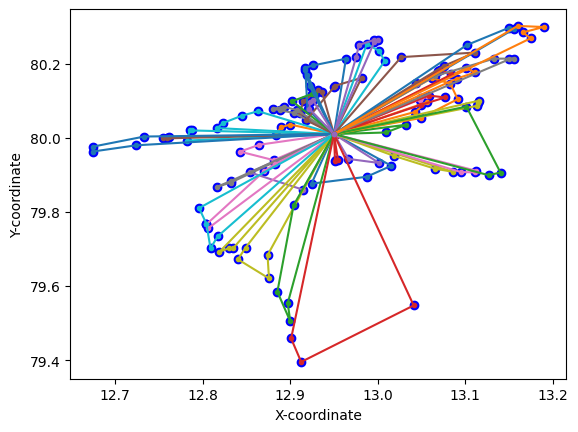

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_routes(routes, customer_locations):
    depot = (12.95, 80.01)
    #depot = (22, 40)
    plt.scatter(*depot, marker='s', color='red', label='Depot')
    # Plot customer locations
    for i, loc in enumerate(customer_locations):
        plt.scatter(*loc, marker='o', color='blue', label=f'Customer {i + 1}')
    # Plot routes
    for r, route in enumerate(routes):
        route_points = [depot]  # Start from depot
        for customer in route:
            route_points.append(customer_locations[customer])
        route_points.append(depot)  # Return to depot
        route_x, route_y = zip(*route_points)
        plt.plot(route_x, route_y, marker='.', label=f'Route {r + 1}', linestyle='-')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.legend()
    #plt.figure(figsize=(8, 8))
    plt.show()

plot_routes(answer[0], node_locations)

In [ ]:
import matplotlib.pyplot as plt

# Data for line 1
runs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
best_distance = answer[2]
#best_distance = []

# Plot all three lines
plt.plot(runs, best_distance)


# Add labels and title
plt.xlabel('Runs')
plt.ylabel('Distance value')
plt.title('Minimising total distance travelled in each run')

# Add legend
plt.legend()

# Display the plot
plt.show()

# Model 3: Genetic Algorithm

In [ ]:
import pandas as pd
import numpy as np
import random
import copy
import math

In [ ]:
df = pd.read_csv('data.csv')
df.head()

,Boarding Points,Latitude,Longitude,Demand
0,Avadi Bs,13.113559,80.086088,16
1,Avadi check post,13.101313,80.084063,17
2,Ponnu super market,13.115993,80.100314,7
3,J.P.Estate,13.114225,80.093337,19
4,Paruthipattu,13.091407,80.104143,12


In [ ]:
# Define problem parameters
num_nodes = len(df)
num_vehicles = 45
vehicle_capacity = 46
depot = (12.95, 80.01)
#depot = (22, 40)

node_locations = [(lat, lon) for lat, lon in zip(df['Latitude'], df['Longitude'])]
node_demands = [dem for dem in df['Demand']]

In [ ]:
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    ans = (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)*111/math.cos((x1+x2)/2)
    return abs(ans)

# Adjust offsprings
def nearest_neighbor_heuristic():
    unvisited_customers = list(range(0, num_nodes))
    routes = [[] for _ in range(num_vehicles)]
    for v in range(num_vehicles):
        capacity = vehicle_capacity
        current_location = (12.95, 80.01)
        #current_location = (22, 40)
        while unvisited_customers:
            nearest_customer = min(unvisited_customers, key=lambda c: distance(current_location, node_locations[c])) #c iterates over the customer indices in the unvisited_customers list.
            if capacity >= node_demands[nearest_customer]:
                routes[v].append(nearest_customer)
                capacity -= node_demands[nearest_customer]
                current_location = node_locations[nearest_customer]
                unvisited_customers.remove(nearest_customer)
            else:
                break  # Vehicle capacity exceeded, start a new route
    print("Initial Solution :", routes)
    return routes

def evaluate_fitness(solution, penalty_coefficient):
    total_distance = 0
    total_penalty = 0
    for route in solution:
        current_location = depot
        route_distance = 0
        route_demand = 0
        for customer in route:
            route_distance += distance(current_location, node_locations[customer])
            current_location = node_locations[customer]
            route_demand += node_demands[customer]
            if route_demand > vehicle_capacity:
                excess_load = route_demand - vehicle_capacity
                total_penalty += excess_load * penalty_coefficient
        route_distance += distance(current_location, depot)
        total_distance += route_distance
    #print("out")
    return total_distance + total_penalty

In [ ]:
import random

def generate_population(population_size, num_nodes, num_vehicles, vehicle_capacity, node_demands):
    population = []
    for _ in range(population_size):
        remaining_customers = list(range(0, num_nodes))
        random.shuffle(remaining_customers)
        routes = [[] for _ in range(num_vehicles)]

        for customer in remaining_customers:
            # Choose a random vehicle
            vehicle_index = random.randint(0, num_vehicles - 1)
            vehicle_route = routes[vehicle_index]

            # Check if adding the customer to the current vehicle's route exceeds its capacity
            if sum(node_demands[node] for node in vehicle_route) + node_demands[customer] <= vehicle_capacity:
                vehicle_route.append(customer)
            else:
                # If adding the customer exceeds the capacity, try adding it to another vehicle
                for other_vehicle_index in range(num_vehicles):
                    if other_vehicle_index != vehicle_index:
                        other_vehicle_route = routes[other_vehicle_index]
                        if sum(node_demands[node] for node in other_vehicle_route) + node_demands[customer] <= vehicle_capacity:
                            other_vehicle_route.append(customer)
                            break  # Stop trying other vehicles
        population.append(routes)
    return population

def two_point_crossover(parent1, parent2):
    crossover_points = sorted(random.sample(range(min(len(parent1), len(parent2))), 2))
    # Create offspring by swapping genetic material between parents
    offspring1 = parent1[:crossover_points[0]] + parent2[crossover_points[0]:crossover_points[1]] + parent1[crossover_points[1]:]
    offspring2 = parent2[:crossover_points[0]] + parent1[crossover_points[0]:crossover_points[1]] + parent2[crossover_points[1]:]
    return offspring1, offspring2

def mutate_vertex_reassignment(current_solution, vertex1, vertex2): #both
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
      if vertex1 in route:
        route1 = route
      if vertex2 in route:
        route2 = route
    index_vertex1 = route1.index(vertex1)
    index_vertex2 = route2.index(vertex2)
    route1.remove(vertex1)
    if route1 == route2:
      if index_vertex1 < index_vertex2:
        route2.insert(index_vertex2-1, vertex1)
      else:
        route2.insert(index_vertex2, vertex1)
    else:
        route2.insert(index_vertex2, vertex1)
    return new_solution

#vertex swap: postions of 2 selected vertices are swapped
def mutate_vertex_swap(current_solution, vertex1, vertex2): #both
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
      if vertex1 in route:
        route1 = route
      if vertex2 in route:
        route2 = route
    index_vertex1 = route1.index(vertex1)
    index_vertex2 = route2.index(vertex2)
    route1[index_vertex1], route2[index_vertex2] = route2[index_vertex2], route1[index_vertex1]
    return new_solution

def reconstruct_offspring(offspring, remaining_customers):
    reconstructed_solution = []

    for route in offspring:
        current_location = depot
        new_route = []

        for customer in route:
            if customer not in new_route:
                # Avoid adding repeated nodes
                new_route.append(customer)

        while remaining_customers:
            # Reapply nearest neighbor heuristic to fill in missing nodes
            nearest_customer = min(remaining_customers, key=lambda c: distance(current_location, node_locations[c]))
            remaining_customers.remove(nearest_customer)
            new_route.append(nearest_customer)
            current_location = node_locations[nearest_customer]

            # Check capacity restrictions
            if sum(node_demands[c] for c in new_route) > vehicle_capacity:
                reconstructed_solution.append(new_route[:-1])  # Exclude the last added customer
                current_location = depot
                new_route = [nearest_customer]

        if new_route:  # Ensure the last route is added to the reconstructed solution
            reconstructed_solution.append(new_route)

    return reconstructed_solution

In [ ]:
gen_population = answer[3]
penalty_coefficient = 20000
solution_value = []
new_population = []
for solution in gen_population:
  value = evaluate_solution(solution, penalty_coefficient)
  if value not in solution_value and value > answer[1]*2:
    solution_value.append(value)
    new_population.append(solution)
print(len(gen_population))
print(len(solution_value))
print(len(new_population))
print(solution_value)

30006
12218
12218
[122282.73235526407, 162299.48300261982, 182261.42467798095, 42259.123136890965, 482272.0775187004, 22285.566329532954, 22311.23019053911, 102355.11366904271, 682284.3007316951, 42349.39923470867, 382253.69460143294, 342252.5879875934, 42281.78615625449, 122395.29256776188, 22402.419944149104, 282312.7881293873, 162416.69305834276, 502303.2876207366, 102396.96172532185, 22280.08711633954, 182272.08978937354, 62370.50423320357, 42333.697556220926, 382303.00649833254, 422292.2858696134, 102298.20432499888, 182281.1747076103, 82314.5169142847, 162279.75339422436, 62264.06379828795, 122294.72571597504, 382268.51572178194, 582260.9028297453, 22437.998672461006, 382278.7233137031, 42285.02939816253, 362271.56141462584, 82377.46122150011, 102365.97522049274, 102292.7631455806, 182327.99314013918, 22271.395234282358, 222286.3793746003, 282321.4168790374, 142312.40966013377, 302315.67527440714, 142364.2168013457, 422322.45999628486, 82315.14787845632, 782342.0654356694, 162357

In [ ]:
def genetic_algorithm(num_nodes, num_generations, num_vehicles, penalty_coefficient, genetic_population):
#def genetic_algorithm(num_nodes, num_generations, num_vehicles, penalty_coefficient):
    #population = generate_population(population_size, num_nodes, num_vehicles, vehicle_capacity, node_demands)
    population = genetic_population
    #best_fitness = evaluate_fitness(best_solution, penalty_coefficient)
    best_fitness = 1000000000000
    best_solution = population[0]
    customer = list(range(0, num_nodes))
    for generation in range(num_generations):
        print("Generation: ", generation)
        # Evaluate fitness of each solution
        fitness_values = [evaluate_fitness(solution, penalty_coefficient) for solution in population]
        #Select the best two solutions
        sorted_indices = sorted(range(len(fitness_values)), key=lambda k: fitness_values[k])
        # parent1_index, parent2_index = sorted_indices[:2]

        parent1_index, parent2_index = random.sample(range(len(population)), 2)
        parent1, parent2 = population[parent1_index], population[parent2_index]
        parent1_fitness = fitness_values[parent1_index]
        parent2_fitness = fitness_values[parent2_index]

        parents = random.sample(population, 2)
        parent1 = parents[0]
        parent2 = parents[1]
        print("Parent1, Parent2: ",parent1_fitness,parent2_fitness )
        # Crossover
        if random.random() < crossover_rate:
            offspring1, offspring2 = two_point_crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2

        # Mutation
        vertex1, vertex2 = random.sample(range(num_nodes), 2)

        remaining_customers_1 = [c for c in customer if all(c not in route for route in offspring1)]
        remaining_customers_2 = [c for c in customer if all(c not in route for route in offspring2)]
        new_offspring1 = reconstruct_offspring(offspring1, remaining_customers_1)
        new_offspring2 = reconstruct_offspring(offspring2, remaining_customers_2)

        move_type = random.choice(['reassignment', 'swap'])
        if move_type == 'reassignment':
            if random.random() < mutation_rate:
                new_offspring1 = mutate_vertex_reassignment(new_offspring1, vertex1, vertex2)
        if move_type == 'swap':
            if random.random() < mutation_rate:
                new_offspring2 = mutate_vertex_swap(new_offspring2, vertex1, vertex2)

        # Choose the best offspring based on fitness with penalty
        offspring1_fitness = evaluate_fitness(new_offspring1, penalty_coefficient)
        offspring2_fitness = evaluate_fitness(new_offspring2, penalty_coefficient)

        if offspring1_fitness < offspring2_fitness:
            best_offspring = new_offspring1
        else:
            best_offspring = new_offspring2
        best_offspring_fitness = evaluate_fitness(best_offspring, penalty_coefficient)
        print("offspring best: ",best_offspring_fitness)
        # Check if the solution has improved
        if best_offspring_fitness < parent1_fitness or best_offspring_fitness < parent2_fitness:
            #print("in")
            # Select the solution in the population to be replaced
            replace_index = fitness_values.index(max(fitness_values))
            population[replace_index] = best_offspring
            if best_offspring_fitness < best_fitness:
              best_fitness = best_offspring_fitness
              best_solution = best_offspring
        else:
            best_fitness = min(fitness_values)
            parent1_best = sorted_indices[0]
            parent1 = population[parent1_best]
            best_solution = parent1
    return best_solution, best_fitness

# Genetic Algorithm parameters
genetic_population = answer[3]
population_size = len(genetic_population)
#genetic_population = new_population
#population_size = len(genetic_population)
#population_size = 10000
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.8
penalty_coefficient = 2000
genetic_solution = genetic_algorithm(num_nodes, num_generations, num_vehicles, penalty_coefficient, genetic_population)
#genetic_solution = genetic_algorithm(num_nodes, num_generations, num_vehicles, penalty_coefficient)
#genetic_distance = evaluate_fitness(genetic_solution, penalty_coefficient)
print("Final Solution:", genetic_solution[0])
print("Final distance:", genetic_solution[1])

Generation:  0
Parent1, Parent2:  56304.9336316768 2251.778108111227
offspring best:  2251.778108111227
Generation:  1
Parent1, Parent2:  6252.072367971652 20276.438118381124
offspring best:  6432.577056491633
Generation:  2
Parent1, Parent2:  4292.588281206386 40253.38913037942
offspring best:  2251.778108111227
Generation:  3
Parent1, Parent2:  2273.167636406755 2305.956222610245
offspring best:  18392.24157709443
Generation:  4
Parent1, Parent2:  26294.611731945395 14342.23213655532
offspring best:  2378.4590962203065
Generation:  5
Parent1, Parent2:  2251.778108111227 22321.076345531477
offspring best:  2280.402904274131
Generation:  6
Parent1, Parent2:  2251.778108111227 18295.29340250961
offspring best:  2251.778108111227
Generation:  7
Parent1, Parent2:  34379.61270648866 2251.778108111227
offspring best:  14315.50127098459
Generation:  8
Parent1, Parent2:  22383.331401403986 2265.33961336653
offspring best:  2251.778108111227
Generation:  9
Parent1, Parent2:  2373.5102094716763

In [ ]:
print(genetic_solution[0])

[[102, 92, 107, 93], [91, 90, 77], [87, 75, 53, 43], [69, 119, 64], [62, 11, 128, 120], [13, 34, 104, 73, 72], [27, 112, 116], [121, 57, 51], [56, 35, 122, 71], [65, 125, 22, 105], [42, 50, 46, 37, 66], [94, 20, 84], [39, 8, 9], [63, 123, 80, 45], [70, 129, 23], [98, 17, 96, 61], [47, 115, 117, 134], [82, 133, 135, 55], [58, 12, 40], [44, 25, 110, 36], [14, 15, 74], [2, 103, 131, 113], [81, 10, 88, 95], [83, 60, 48], [49, 26, 111, 85], [6, 1], [3], [99], [18, 30, 38], [54, 109], [7, 76], [127, 59, 52, 124], [], [108], [67, 118], [78, 79], [21, 106, 16], [100, 101], [], [126, 4, 130], [19, 89, 86, 31], [97, 29], [114, 132, 41], [32, 5, 33], [68, 24, 28]]


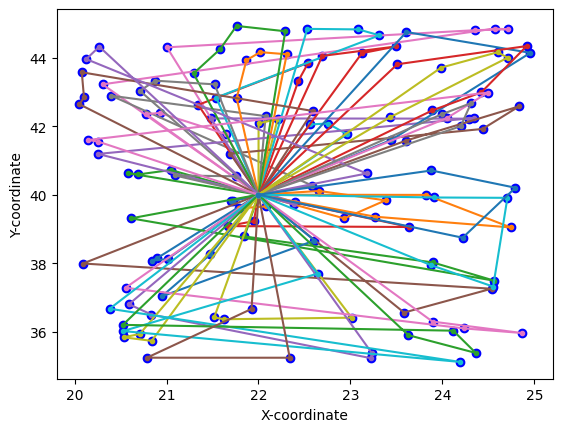

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_routes(routes, customer_locations):
    #depot = (12.95, 80.01)
    depot = (22, 40)
    plt.scatter(*depot, marker='s', color='red', label='Depot')
    # Plot customer locations
    for i, loc in enumerate(customer_locations):
        plt.scatter(*loc, marker='o', color='blue', label=f'Customer {i + 1}')
    # Plot routes
    for r, route in enumerate(routes):
        route_points = [depot]  # Start from depot
        for customer in route:
            route_points.append(customer_locations[customer])
        route_points.append(depot)  # Return to depot
        route_x, route_y = zip(*route_points)
        plt.plot(route_x, route_y, marker='.', label=f'Route {r + 1}', linestyle='-')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.legend()
    #plt.figure(figsize=(8, 8))
    plt.show()

plot_routes(genetic_solution[0], node_locations)

# Genetic using PyGad Library

In [ ]:
!pip install pygad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


## Single depot case

In [ ]:
!pip install pygad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pygad
import math
import random

# Define problem parameters
df = pd.read_csv('data.csv')
num_nodes = len(df)
num_vehicles = 45
vehicle_capacity = 46
depot = (12.95, 80.01)
node_locations = [(lat, lon) for lat, lon in zip(df['Latitude'], df['Longitude'])]
node_demands = [dem for dem in df['Demand']]

#Distance functions
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    ans = (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)*111/math.cos((x1+x2)/2)
    return abs(ans)

distance_matrix = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        distance_matrix[i][j] = distance(node_locations[i], node_locations[j])

In [ ]:
#generate custom initial population
def generate_population(population_size, num_nodes, num_vehicles, vehicle_capacity, node_demands):
    population = []
    for _ in range(population_size):
        remaining_customers = list(range(0, num_nodes))
        random.shuffle(remaining_customers)
        routes = [[] for _ in range(num_vehicles)]

        for customer in remaining_customers:
            # Choose a random vehicle
            vehicle_index = random.randint(0, num_vehicles - 1)
            vehicle_route = routes[vehicle_index]

            # Check if adding the customer to the current vehicle's route exceeds its capacity
            if sum(node_demands[node] for node in vehicle_route) + node_demands[customer] <= vehicle_capacity:
                vehicle_route.append(customer)
            else:
                # If adding the customer exceeds the capacity, try adding it to another vehicle
                for other_vehicle_index in range(num_vehicles):
                    if other_vehicle_index != vehicle_index:
                        other_vehicle_route = routes[other_vehicle_index]
                        if sum(node_demands[node] for node in other_vehicle_route) + node_demands[customer] <= vehicle_capacity:
                            other_vehicle_route.append(customer)
                            break  # Stop trying other vehicles
        #flat_routes = [node for route in routes for node in route]
        population.append(routes)
    return population

population_size = 1000
initial_population = generate_population(population_size, num_nodes, num_vehicles, vehicle_capacity, node_demands)

custom_initial_population = []
for random_solution in initial_population:
    converted_solution = [0] * num_nodes
    for vehicle, route in enumerate(random_solution):
        for node in route:
            converted_solution[node] = vehicle
    custom_initial_population.append(converted_solution)
custom_initial_population = np.array(custom_initial_population)

In [ ]:
#use the population generated via Tabu search
custom_initial_population = []
for random_solution in answer[3]:
    converted_solution = [0] * num_nodes
    for vehicle, route in enumerate(random_solution):
        for node in route:
            converted_solution[node] = vehicle
    custom_initial_population.append(converted_solution)
custom_initial_population = np.array(custom_initial_population)

In [ ]:
# Fitness function for single depot
def fitness_func(ga_instance, solution, solution_idx):
    route_distances = np.zeros(num_vehicles)
    route_demands = np.zeros(num_vehicles)
    # Decode the solution
    routes = [[] for _ in range(num_vehicles)]
    for node, vehicle in zip(range(0, num_nodes), solution):
        routes[vehicle].append(node)

    # Calculate route distances and demands
    for i, route in enumerate(routes):
        if len(route) > 0:
            route_distance = 0
            route_demand = 0
            for j in range(len(route) - 1):  # Iterate over pairs of consecutive nodes
                # Calculate distance between consecutive nodes and add to total route distance
                node1 = route[j]
                node2 = route[j + 1]
                route_distance += distance_matrix[node1][node2]
                route_demand += node_demands[node1]
            route_demand += node_demands[route[-1]]
            route_distance += distance(depot,node_locations[route[0]]) + distance(depot,node_locations[route[-1]])
            route_distances[i] = route_distance
            route_demands[i] = route_demand
    # Check if constraints are satisfied
    vehicle_capacity = 46
    penalty_coefficient = 20000
    total_penalty = 0
    for route_demand in route_demands:
        if route_demand > vehicle_capacity:
            excess_load = route_demand - vehicle_capacity
            total_penalty += excess_load * penalty_coefficient

    # Calculate fitness (minimize total distance)
    fitness = np.sum(route_distances) + total_penalty
    print(f"Evaluating solution {solution_idx}: {fitness}")
    return 1/fitness  # Maximizing fitness

In [ ]:
# Create Genetic Algorithm instance
ga_instance = pygad.GA(num_generations=10,
                       num_parents_mating=10,
                       fitness_func=fitness_func,
                       sol_per_pop=50,
                       num_genes=num_nodes,
                       gene_type=int,
                       parent_selection_type="tournament",
                       K_tournament=10,
                       crossover_type="two_points",
                       crossover_probability = 0.8,
                       initial_population = custom_initial_population,
                       mutation_type="swap",
                       mutation_percent_genes=10,
                       mutation_num_genes=2,
                       mutation_probability = 0.8,
                       keep_parents=0)

In [ ]:
# Run the Genetic Algorithm
ga_instance.run()
# Get the best solution after running the GA
best_solution = ga_instance.best_solution()

#### Results

In [ ]:
print(best_solution[0])

[ 9 29 33 21 22  4  5 10 27 28  1 30 20 38  0  1 12 25 26  8 37 23 10 22
 28 39 29  1 22 10 15 26 13 13 44 13 38  0  6 25 26 34 44 24  2 34 19 14
 29 11 11 24 15  0 21 17 44 16 24  6 33 43 16 41  9 39 44 19 15  7  4 43
 38  9  5 28 23 27  7  6 18 20  5 18  8 31 24 43  2 20  2 26 12 17  1 42
 42 41  3  4 27  7  3  3 22  5  3 15 17 12 17  2 11 31 44 38 16 14 19 23
 14 21 11  9 36 32  8 32 14 33 33 18 14 31 34 41]


In [ ]:
# Decode the best solution
best_routes = [[] for _ in range(num_vehicles)]
for node, vehicle in zip(range(0, num_nodes), best_solution[0]):
    best_routes[vehicle].append(node)
print("Best solution:", best_routes)

Best solution: [[14, 37, 53], [10, 15, 27, 94], [44, 88, 90, 111], [98, 102, 103, 106], [5, 70, 99], [6, 74, 82, 105], [38, 59, 79], [69, 78, 101], [19, 84, 126], [0, 64, 73, 123], [7, 22, 29], [49, 50, 112, 122], [16, 92, 109], [32, 33, 35], [47, 117, 120, 128, 132], [30, 52, 68, 107], [57, 62, 116], [55, 93, 108, 110], [80, 83, 131], [46, 67, 118], [12, 81, 89], [3, 54, 121], [4, 23, 28, 104], [21, 76, 119], [43, 51, 58, 86], [17, 39], [18, 31, 40, 91], [8, 77, 100], [9, 24, 75], [1, 26, 48], [11], [85, 113, 133], [125, 127], [2, 60, 129, 130], [41, 45, 134], [], [124], [20], [13, 36, 72, 115], [25, 65], [], [63, 97, 135], [95, 96], [61, 71, 87], [34, 42, 56, 66, 114]]


In [ ]:
route_demands = []
for route in best_routes:
  route_demand = 0
  for node in route:
    route_demand += node_demands[node]
  route_demands.append(route_demand)
route_demand_dict = dict(zip(range(len(best_routes)), route_demands))
print("Route Demands:", route_demand_dict)

Route Demands: {0: 43, 1: 45, 2: 46, 3: 46, 4: 44, 5: 42, 6: 46, 7: 42, 8: 46, 9: 46, 10: 45, 11: 45, 12: 46, 13: 43, 14: 43, 15: 41, 16: 46, 17: 45, 18: 44, 19: 41, 20: 46, 21: 44, 22: 45, 23: 46, 24: 40, 25: 37, 26: 45, 27: 38, 28: 43, 29: 39, 30: 19, 31: 31, 32: 31, 33: 46, 34: 42, 35: 0, 36: 7, 37: 16, 38: 44, 39: 34, 40: 0, 41: 41, 42: 21, 43: 33, 44: 41}


In [ ]:
total_distance = 0
for i, route in enumerate(best_routes):
    if len(route) > 0:
        route_distance = 0
        for j in range(len(route) - 1):
            node1 = route[j]
            node2 = route[j + 1]
            route_distance += distance_matrix[node1][node2]
        route_distance += distance(depot,node_locations[route[0]]) + distance(depot,node_locations[route[-1]])
    total_distance += route_distance
vehicle_capacity = 46
penalty_coefficient = 20000
total_penalty = 0
for route_demand in route_demands:
    if route_demand > vehicle_capacity:
        excess_load = route_demand - vehicle_capacity
        total_penalty += excess_load * penalty_coefficient

# Calculate fitness (minimize total distance)
total_distance += total_penalty
print("Total final optimal distance:", total_distance)

Total final optimal distance: 4779.066258491108


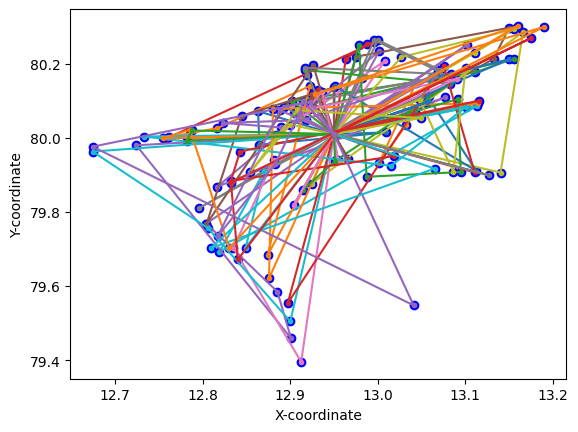

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_routes(routes, customer_locations):
    depot = (12.95, 80.01)
    #depot = (22, 40)
    plt.scatter(*depot, marker='s', color='red', label='Depot')
    # Plot customer locations
    for i, loc in enumerate(customer_locations):
        plt.scatter(*loc, marker='o', color='blue', label=f'Customer {i + 1}')
    # Plot routes
    for r, route in enumerate(routes):
        route_points = [depot]  # Start from depot
        for customer in route:
            route_points.append(customer_locations[customer])
        route_points.append(depot)  # Return to depot
        route_x, route_y = zip(*route_points)
        plt.plot(route_x, route_y, marker='.', label=f'Route {r + 1}', linestyle='-')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.legend()
    #plt.figure(figsize=(8, 8))
    plt.show()

plot_routes(best_routes, node_locations)

## Multiple depot case

### Method 1, Depots = no. of vehicles (such that start node of the route is a depot)

In [ ]:
# Fitness function
def fitness_func_multi(ga_instance, solution, solution_idx):
    route_distances = np.zeros(num_vehicles)
    route_demands = np.zeros(num_vehicles)
    # Decode the solution
    routes = [[] for _ in range(num_vehicles)]
    for node, vehicle in zip(range(0, num_nodes), solution):
        routes[vehicle].append(node)

    # Calculate route distances and demands
    for i, route in enumerate(routes):
        if len(route) > 0:
            route_distance = 0
            route_demand = 0
            for j in range(len(route) - 1):  # Iterate over pairs of consecutive nodes
                # Calculate distance between consecutive nodes and add to total route distance
                node1 = route[j]
                node2 = route[j + 1]
                route_distance += distance_matrix[node1][node2]
                route_demand += node_demands[node1]
            route_demand += node_demands[route[-1]]
            route_distance += distance(depot,node_locations[route[-1]])
            route_distances[i] = route_distance
            route_demands[i] = route_demand
    # Check if constraints are satisfied
    vehicle_capacity = 46
    penalty_coefficient = 20000
    total_penalty = 0
    for route_demand in route_demands:
        if route_demand > vehicle_capacity:
            excess_load = route_demand - vehicle_capacity
            total_penalty += excess_load * penalty_coefficient

    # Calculate fitness (minimize total distance)
    fitness = np.sum(route_distances) + total_penalty
    print(f"Evaluating solution {solution_idx}: {fitness}")
    return 1/fitness  # Maximizing fitness

In [ ]:
#generate custom initial population
def generate_population(population_size, num_nodes, num_vehicles, vehicle_capacity, node_demands):
    population = []
    for _ in range(population_size):
        remaining_customers = list(range(0, num_nodes-num_vehicles-1))
        random.shuffle(remaining_customers)
        routes = [[] for _ in range(num_vehicles)]

        for customer in remaining_customers:
            # Choose a random vehicle
            vehicle_index = random.randint(0, num_vehicles - 1)
            vehicle_route = routes[vehicle_index]

            depot_index = vehicle_index + num_nodes - num_vehicles
            if depot_index not in vehicle_route:
                vehicle_route.append(depot_index)

            if sum(node_demands[node] for node in vehicle_route) + node_demands[customer] <= vehicle_capacity:
                vehicle_route.append(customer)
            else:
                # If adding the customer exceeds the capacity, try adding it to another vehicle
                for other_vehicle_index in range(num_vehicles):
                    if other_vehicle_index != vehicle_index:
                        other_vehicle_route = routes[other_vehicle_index]
                        if sum(node_demands[node] for node in other_vehicle_route) + node_demands[customer] <= vehicle_capacity:
                            other_vehicle_route.append(customer)
                            break  # Stop trying other vehicles
        #flat_routes = [node for route in routes for node in route]
        population.append(routes)
    return population

population_size = 10000
initial_population = generate_population(population_size, num_nodes, num_vehicles, vehicle_capacity, node_demands)

custom_initial_population = []
for random_solution in initial_population:
    converted_solution = [0] * num_nodes
    for vehicle, route in enumerate(random_solution):
        for node in route:
            converted_solution[node] = vehicle
    custom_initial_population.append(converted_solution)
custom_initial_population = np.array(custom_initial_population)

In [ ]:
custom_initial_population[0]

array([24, 29, 33,  2, 24, 26, 11, 33, 12, 17, 27,  3, 38,  4,  3, 15, 37,
       21, 44, 27, 31, 23,  0, 44, 18, 19, 13, 41,  9, 14, 18,  8,  6, 10,
       41,  5, 12,  0,  8,  1,  7, 16, 42,  7, 28, 19,  4, 25, 11,  1,  0,
       20, 31,  1, 43, 13, 21,  0,  7, 35, 43, 32, 37, 16,  9, 22,  5, 34,
       30,  5,  8, 38, 13, 33,  6,  9,  2, 12, 14, 27, 20,  4, 28, 32, 10,
       34, 43, 15,  6, 25,  0,  0,  1,  2,  3,  4,  0,  6,  7,  8,  0,  0,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28,  0, 30, 31, 32, 33, 34, 35,  0, 37, 38,  0,  0, 41, 42, 43, 44])

In [ ]:
# Create Genetic Algorithm instance
ga_instance_multi = pygad.GA(num_generations=10,
                       num_parents_mating=10,
                       fitness_func=fitness_func_multi,
                       sol_per_pop=50,
                       num_genes=num_nodes,
                       gene_type=int,
                       parent_selection_type="tournament",
                       K_tournament=10,
                       crossover_type="two_points",
                       crossover_probability = 0.8,
                       initial_population = custom_initial_population,
                       mutation_type="swap",
                       mutation_percent_genes=10,
                       mutation_num_genes=2,
                       mutation_probability = 0.8,
                       keep_parents=0)

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [ ]:
# Run the Genetic Algorithm
ga_instance_multi.run()
# Get the best solution after running the GA
best_solution_multi = ga_instance_multi.best_solution()

Streaming output truncated to the last 5000 lines.
Evaluating solution 5000: 1224392.5424179074
Evaluating solution 5001: 1584295.9399755343
Evaluating solution 5002: 1324457.6606926834
Evaluating solution 5003: 1944396.8244257146
Evaluating solution 5004: 1484436.8389916015
Evaluating solution 5005: 1224451.496425188
Evaluating solution 5006: 1264428.7884800704
Evaluating solution 5007: 1604412.7221390652
Evaluating solution 5008: 1224456.3362881315
Evaluating solution 5009: 1484420.7288424629
Evaluating solution 5010: 1344459.2056691276
Evaluating solution 5011: 1224461.4082443689
Evaluating solution 5012: 844428.5992715148
Evaluating solution 5013: 1204387.729131572
Evaluating solution 5014: 1224445.907487033
Evaluating solution 5015: 1384389.3830896355
Evaluating solution 5016: 1004424.3770579487
Evaluating solution 5017: 1564473.2812704835
Evaluating solution 5018: 1384355.1495157746
Evaluating solution 5019: 1364369.884564436
Evaluating solution 5020: 1324453.7328071645
Evaluatin

#### Results

In [ ]:
print(best_solution_multi[0])

[ 7 25 15 27 37 16 22  3 19 21  9  2  0 41 40 29  8 10  3 20 24 15 41  1
  7 13 24 30  4 13  2 26 34 18 28 44 32 23  6 35 33  4  0 21 23  5 20  7
 22 38 36 23 34 26 25 27 39  1  9 32 17  8 19  2 28 20 15 19 31  6 14 36
 11 21 27 43 12 10 42 12 16  3 10  5 14 24 17  5  8 11  0  0  1  2  3  4
  5  6  7  8  9  0 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


In [ ]:
# Decode the best solution
best_routes_multi = [[] for _ in range(num_vehicles)]
for node, vehicle in zip(range(0, num_nodes), best_solution_multi[0]):
    best_routes_multi[vehicle].append(node)
print("Best solution:", best_routes_multi)

Best solution: [[12, 42, 90, 91, 101], [23, 57, 92], [11, 30, 63, 93], [7, 18, 81, 94], [28, 41, 95], [45, 83, 87, 96], [38, 69, 97], [0, 24, 47, 98], [16, 61, 88, 99], [10, 58, 100], [17, 77, 82], [72, 89, 102], [76, 79, 103], [25, 29, 104], [70, 84, 105], [2, 21, 66, 106], [5, 80, 107], [60, 86, 108], [33, 109], [8, 62, 67, 110], [19, 46, 65, 111], [9, 43, 73, 112], [6, 48, 113], [37, 44, 51, 114], [20, 26, 85, 115], [1, 54, 116], [31, 53, 117], [3, 55, 74, 118], [34, 64, 119], [15, 120], [27, 121], [68, 122], [36, 59, 123], [40, 124], [32, 52, 125], [39, 126], [50, 71, 127], [4, 128], [49, 129], [56, 130], [14, 131], [13, 22, 132], [78, 133], [75, 134], [35, 135]]


In [ ]:
# Calculate total distance for the modified route
#Distance functions
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    ans = (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)*111/math.cos((x1+x2)/2)
    return abs(ans)

total_distance = 0
for route in best_routes_multi:
    route_distance = 0
    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i + 1]
        route_distance += distance(node_locations[node1], node_locations[node2])
    route_distance += distance(depot,node_locations[route[-1]])
    total_distance += route_distance
print(total_distance)

4131.214340205946


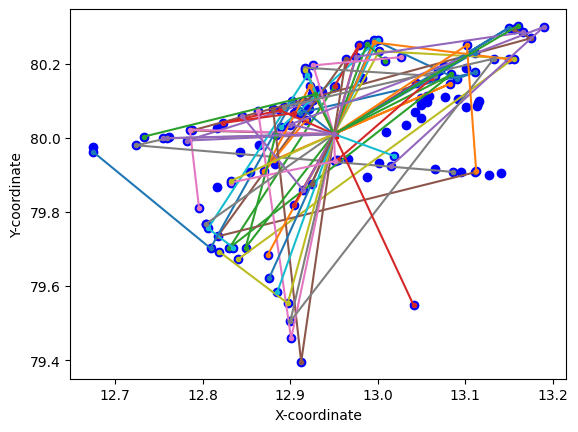

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_routes(routes, customer_locations):
    depot = (12.95, 80.01)

    plt.scatter(*depot, marker='s', color='red', label='Depot')
    #plt.scatter(*vehicle_locations, marker='s', color='red', label='Depot')
    # Plot customer locations
    for i, loc in enumerate(customer_locations):
        plt.scatter(*loc, marker='o', color='blue', label=f'Customer {i + 1}')

    # Plot routes
    for r, route in enumerate(routes):
        #route_points = [depot]  # Start from depot
        #route_points = [vehicle_locations[route[0]]]
        route_points = []
        for customer in route[1:]:
            route_points.append(customer_locations[customer])
        route_points.append(depot)  # Return to depot
        route_x, route_y = zip(*route_points)
        plt.plot(route_x, route_y, marker='.', label=f'Route {r + 1}', linestyle='-')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.legend()
    #plt.figure(figsize=(8, 8))
    plt.show()

plot_routes(best_routes_multi, node_locations)

### Method 2, Depots = no. of vehicles (such that depots node co-ordinates are provided) each route chooses best depot for itself

In [ ]:
# Loading the depots
depots = pd.read_csv('depots.csv')
num_depots = len(depots)
depot_locations = [(lat, lon) for lat, lon in zip(depots['Latitude'], depots['Longitude'])]

In [ ]:
len(depot_locations)

45

#### Results

In [ ]:
# Assigning the best possible vehicle to minimize distance, to each of the routes obtained in best solution above

def new_routes(best_routes_multi,depot_locations,node_locations):
    # Assign one depot to each route in the best solution
    assigned_routes = []
    total_distance = 0
    assigned_depot_indices = set()  # Keep track of assigned depot indices
    random.shuffle(best_routes_multi)
    for route in best_routes_multi:
        min_distance = float('inf')
        selected_depot = None

        for depot_index, depot_loc in enumerate(depot_locations):
            #if depot_index not in assigned_depot_indices:  # Check if the depot index is not already assigned
                depot_distance = distance(depot_loc, node_locations[route[0]])
                if depot_distance < min_distance:
                    min_distance = depot_distance
                    selected_depot = depot_index

        # Update the assigned depot index set
        assigned_depot_indices.add(selected_depot)

        # Update the route with the assigned depot at the beginning
        assigned_route = [selected_depot] + route

        # Calculate total distance for the modified route
        route_distance = 0
        for i in range(len(route) - 1):
            node1 = assigned_route[i]
            node2 = assigned_route[i + 1]
            route_distance += distance_matrix[node1][node2]
        route_distance += distance(node_locations[route[0]],depot_locations[assigned_route[0]]) + distance(depot,node_locations[assigned_route[-1]])
        total_distance += route_distance
        assigned_routes.append(assigned_route)

    return assigned_routes, total_distance

iterations = 100000
best_distance = float('inf')
best_routes = []
for _ in range(iterations):
  assigned_routes, total_distance = new_routes(best_routes_multi,depot_locations,node_locations)
  if total_distance < best_distance:
    best_distance = total_distance
    best_routes = assigned_routes


print("Assigned Routes:", best_routes)
print("Total Distance:", best_distance)

Assigned Routes: [[16, 1, 54, 116], [16, 31, 53, 117], [16, 7, 18, 81, 94], [16, 35, 135], [12, 56, 130], [16, 3, 55, 74, 118], [16, 11, 30, 63, 93], [25, 23, 57, 92], [19, 45, 83, 87, 96], [16, 8, 62, 67, 110], [16, 2, 21, 66, 106], [12, 72, 89, 102], [12, 17, 77, 82], [16, 14, 131], [12, 16, 61, 88, 99], [16, 6, 48, 113], [25, 19, 46, 65, 111], [16, 78, 133], [16, 13, 22, 132], [16, 10, 58, 100], [25, 28, 41, 95], [16, 37, 44, 51, 114], [16, 39, 126], [21, 70, 84, 105], [25, 20, 26, 85, 115], [34, 60, 86, 108], [6, 68, 122], [16, 36, 59, 123], [16, 38, 69, 97], [16, 5, 80, 107], [4, 49, 129], [25, 25, 29, 104], [16, 15, 120], [16, 76, 79, 103], [25, 27, 121], [16, 32, 52, 125], [16, 12, 42, 90, 91, 101], [16, 0, 24, 47, 98], [16, 9, 43, 73, 112], [16, 34, 64, 119], [16, 4, 128], [16, 40, 124], [16, 75, 134], [4, 50, 71, 127], [16, 33, 109]]
Total Distance: 4639.741092413354


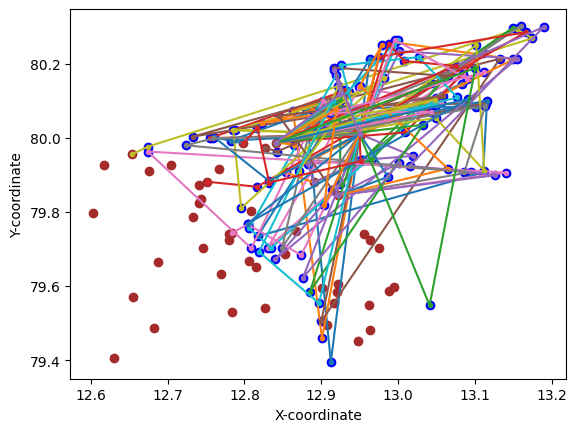

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_routes(routes, customer_locations, vehicle_locations):
    depot = (12.95, 80.01)

    plt.scatter(*depot, marker='s', color='red', label='Depot')
    #plt.scatter(*vehicle_locations, marker='s', color='red', label='Depot')
    # Plot customer locations
    for i, loc in enumerate(customer_locations):
        plt.scatter(*loc, marker='o', color='blue', label=f'Customer {i + 1}')
    # Plot depot locations
    for i, loc in enumerate(vehicle_locations):
        plt.scatter(*loc, marker='o', color='brown', label=f'Vehicle {i + 1}')

    # Plot routes
    for r, route in enumerate(routes):
        #route_points = [depot]  # Start from depot
        # print(route[0])
        # print(vehicle_locations[route[0]])
        route_points = [vehicle_locations[route[0]]]
        #route_points = []
        for customer in route[1:]:
            route_points.append(customer_locations[customer])
        route_points.append(depot)  # Return to depot
        route_x, route_y = zip(*route_points)
        plt.plot(route_x, route_y, marker='.', label=f'Route {r + 1}', linestyle='-')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.legend()
    #plt.figure(figsize=(8, 8))
    plt.show()

plot_routes(best_routes, node_locations, depot_locations)

# Stochastic VRP

## Model 1: Demand based routing

In [ ]:
import pandas as pd
import numpy as np
import random
import copy
import math

In [ ]:
df = pd.read_csv('stochastic_data.csv')
df

,Boarding Points,Latitude,Longitude,Demand
0,Avadi Bs,12.637707,79.056708,4
1,Avadi check post,12.587197,78.267467,5
2,Spr checkpost,11.991501,79.127196,7
3,Spr Bs,11.422752,78.522098,6
4,High school,12.352879,79.901597,2
5,Thiruvallur Bs,12.542387,79.262308,1
6,Kakkallur Signal,12.725945,78.891710,5
7,Manavalanagar Bridge,11.459452,79.623934,7
8,Manavalanagar Signal,11.502646,79.812364,8
9,Keel Nallathur,11.284710,79.991654,1


In [ ]:
# Define problem parameters
num_nodes = len(df)
num_vehicles = 1
vehicle_capacity = 50
depot = (12.25, 79.25)

node_locations = [(lat, lon) for lat, lon in zip(df['Latitude'], df['Longitude'])]
node_demands = [dem for dem in df['Demand']]

In [ ]:
#Helping functions for Tabu Search
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    ans = (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)*111/math.cos((x1+x2)/2)
    return abs(ans)

def nearest_neighbor_heuristic():
    unvisited_customers = list(range(0, num_nodes))
    routes = [[] for _ in range(num_vehicles)]
    for v in range(num_vehicles):
        capacity = vehicle_capacity
        current_location = (12.95, 80.01)
        while unvisited_customers:
            nearest_customer = min(unvisited_customers, key=lambda c: distance(current_location, node_locations[c])) #c iterates over the customer indices in the unvisited_customers list.
            if capacity >= node_demands[nearest_customer]:
                routes[v].append(nearest_customer)
                capacity -= node_demands[nearest_customer]
                current_location = node_locations[nearest_customer]
                unvisited_customers.remove(nearest_customer)
            else:
                break  # Vehicle capacity exceeded, start a new route
    print("Initial Solution :", routes)
    return routes

def evaluate_solution(solution, penalty_coefficient):
    total_distance = 0
    total_penalty = 0
    for route in solution:
        current_location = depot
        route_distance = 0
        route_demand = 0
        for customer in route:
            route_distance += distance(current_location, node_locations[customer])
            current_location = node_locations[customer]
            route_demand += node_demands[customer]
            if route_demand > vehicle_capacity:
                excess_load = route_demand - vehicle_capacity
                total_penalty += excess_load * penalty_coefficient
        route_distance += distance(current_location, depot)
        total_distance += route_distance
    return total_distance + total_penalty
    #return total_distance

In [ ]:
#vertex reassignment: 1st selected vertex is removed from position and added in position before the 2nd selected vertex
def apply_vertex_reassignment(current_solution, vertex1, vertex2): #both
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
      if vertex1 in route:
        route1 = route
      if vertex2 in route:
        route2 = route
    index_vertex1 = route1.index(vertex1)
    index_vertex2 = route2.index(vertex2)
    route1.remove(vertex1)
    if route1 == route2:
      if index_vertex1 < index_vertex2:
        route2.insert(index_vertex2-1, vertex1)
      else:
        route2.insert(index_vertex2, vertex1)
    else:
        route2.insert(index_vertex2, vertex1)
    return new_solution

#vertex swap: postions of 2 selected vertices are swapped
def apply_vertex_swap(current_solution, vertex1, vertex2): #both
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
      if vertex1 in route:
        route1 = route
      if vertex2 in route:
        route2 = route
    index_vertex1 = route1.index(vertex1)
    index_vertex2 = route2.index(vertex2)
    route1[index_vertex1], route2[index_vertex2] = route2[index_vertex2], route1[index_vertex1]
    return new_solution

# 2-opt: all elements between two selected vertices are interchanged
def apply_2_opt(current_solution, vertex1, vertex2): #within a selected route
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
        if vertex1 in route and vertex2 in route:
            index_vertex1 = route.index(vertex1)
            index_vertex2 = route.index(vertex2)
            if index_vertex1 < index_vertex2:
                route[index_vertex1+1:index_vertex2] = reversed(route[index_vertex1+1:index_vertex2])
            else:
                route[index_vertex2+1:index_vertex1] = reversed(route[index_vertex2+1:index_vertex1])
    return new_solution

#tail swap: tails after two selected vertices are swapped till the end of the selected route
def apply_tail_swap(current_solution, vertex1, vertex2): # between 2 different routes
    new_solution = copy.deepcopy(current_solution)
    route1, route2 = [], []
    for route in new_solution:
      if vertex1 in route:
        route1 = route
      if vertex2 in route:
        route2 = route
    if route1 != route2:
      index_vertex1 = route1.index(vertex1)
      index_vertex2 = route2.index(vertex2)
      route1[index_vertex1 + 1:], route2[index_vertex2 + 1:] = route2[index_vertex2 + 1:], route1[index_vertex1 + 1:]
    return new_solution

def tabu_search(initial_solution, max_iter, max_cons_iter, max_cand_list, penalty_coefficient):
    current_solution = copy.deepcopy(initial_solution)
    best_solution = copy.deepcopy(initial_solution)
    tabu_list = []
    initial_solution_value = evaluate_solution(best_solution, penalty_coefficient)
    print("Initial solution: ",initial_solution_value)
    iter, cons_iter, cand_list = 0, 0, 0
    genetic_population = []
    final_distance = 0
    #while iter <= max_iter and cons_iter <= max_cons_iter:
    while iter <= max_iter:
        #while cand_list <= max_cand_list:
        while cons_iter <= max_cons_iter:
            #print(best_solution)
            vertex1, vertex2 = random.sample(range(num_nodes), 2)
            #print(vertex1,vertex2)
            move_type = random.choice(['reassignment', 'swap', '2-opt', 'tail_swap'])
            #print(move_type)
            if move_type == 'reassignment':
                candidate_solution = apply_vertex_reassignment(current_solution, vertex1, vertex2)
            elif move_type == 'swap':
                candidate_solution = apply_vertex_swap(current_solution, vertex1, vertex2)
            elif move_type == '2-opt':
                candidate_solution = apply_2_opt(current_solution, vertex1, vertex2)
            elif move_type == 'tail_swap':
                candidate_solution = apply_tail_swap(current_solution, vertex1, vertex2)

            genetic_population.append(candidate_solution)
            # Evaluate the candidate solution
            candidate_value = evaluate_solution(candidate_solution, penalty_coefficient)

            # Check if the move is not Tabu or it produces a better solution
            if (vertex1, vertex2) not in tabu_list and candidate_value < evaluate_solution(best_solution, penalty_coefficient):
                #print(candidate_value)
                #print("I am better")
                best_solution = copy.deepcopy(candidate_solution)
                cons_iter = 0  # Reset consecutive iterations without improvement
                tabu_list.append((vertex1, vertex2))  # Add the move to the Tabu list
                current_solution = candidate_solution
                #genetic_population.append(current_solution)
                if len(tabu_list) > 5:  # Keep the Tabu list length within a limit
                    tabu_list.pop(0)
                break

            #cand_list += 1
            #print(cand_list)
            cons_iter += 1

        iter += 1
        #print(iter)
        cons_iter = 0
            #cand_list = 0
        final_distance = evaluate_solution(best_solution, penalty_coefficient)
    return best_solution, final_distance, genetic_population

def run_tabu():
    #initial_solution = best_solution
    max_iterations = 5000
    max_consecutive_iterations = 5
    max_candidate_list_size = 5
    penalty_coefficient = 20000
    #genetic_population = []
    distance_values = []
    tolerance = 0
    for i in range(1,51):
      if i == 1:
        initial_solution = nearest_neighbor_heuristic()
        #initial_solution = genetic_solution[0]
        print("Run: ", i)
        final_solution = tabu_search(initial_solution, max_iterations, max_consecutive_iterations, max_candidate_list_size, penalty_coefficient)
        print("Final Solution:", final_solution[0])
        print("Final distance:", final_solution[1])
        distance_values.append(final_solution[1])
      else:
        initial_solution = final_solution[0]
        print("Run: ", i)
        final_solution = tabu_search(initial_solution, max_iterations, max_consecutive_iterations, max_candidate_list_size, penalty_coefficient)
        #final_distance = evaluate_solution(final_solution, penalty_coefficient)
        print("Final Solution:", final_solution[0])
        print("Final distance:", final_solution[1])
        distance_values.append(final_solution[1])
        if abs(distance_values[i-2]-distance_values[i-1]) <= 5:
          tolerance += 1
        else:
          tolerance = 0
        if tolerance == 10:
          break
      print(distance_values)
    return final_solution[0], final_solution[1], distance_values, final_solution[2]

In [ ]:
answer = run_tabu()
print("Best solution tabu search: ", answer[0])
print("Best distance tabu search: ", answer[1])

Initial Solution : [[4, 5, 0, 6, 1, 2, 7, 8, 9, 3]]
Run:  1
Initial solution:  1267.9246369263285
Final Solution: [[4, 9, 8, 7, 5, 0, 6, 1, 3, 2]]
Final distance: 965.0090137166371
[965.0090137166371]
Run:  2
Initial solution:  965.0090137166371
Final Solution: [[4, 9, 8, 7, 5, 0, 6, 1, 3, 2]]
Final distance: 965.0090137166371
[965.0090137166371, 965.0090137166371]
Run:  3
Initial solution:  965.0090137166371
Final Solution: [[4, 9, 8, 7, 5, 0, 6, 1, 3, 2]]
Final distance: 965.0090137166371
[965.0090137166371, 965.0090137166371, 965.0090137166371]
Run:  4
Initial solution:  965.0090137166371
Final Solution: [[4, 9, 8, 7, 5, 0, 6, 1, 3, 2]]
Final distance: 965.0090137166371
[965.0090137166371, 965.0090137166371, 965.0090137166371, 965.0090137166371]
Run:  5
Initial solution:  965.0090137166371
Final Solution: [[4, 9, 8, 7, 5, 0, 6, 1, 3, 2]]
Final distance: 965.0090137166371
[965.0090137166371, 965.0090137166371, 965.0090137166371, 965.0090137166371, 965.0090137166371]
Run:  6
Initial s

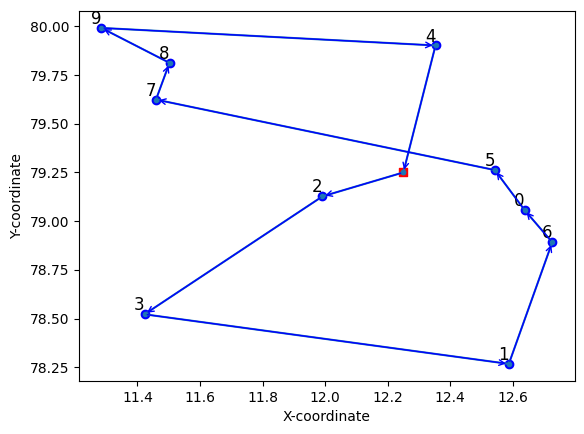

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_routes(routes, customer_locations):
    depot = (12.25, 79.25)
    plt.scatter(*depot, marker='s', color='red', label='Depot')
    # Plot customer locations
    for i, loc in enumerate(customer_locations):
        plt.scatter(*loc, marker='o', color='blue', label=f'Customer {i + 1}')
        plt.text(loc[0], loc[1], str(i), color='black', fontsize=12, ha='right', va='bottom')
    # Plot routes
    for r, route in enumerate(routes):
        route_points = [depot]  # Start from depot
        for customer in route:
            route_points.append(customer_locations[customer])
        route_points.append(depot)  # Return to depot
        route_x, route_y = zip(*route_points)
        plt.plot(route_x, route_y, marker='.', label=f'Route {r + 1}', linestyle='-')

    # Add arrows on the route line
    for i in range(len(route)+1):
        dx = route_points[i+1][0] - route_points[i][0]
        dy = route_points[i+1][1] - route_points[i][1]
        plt.annotate("", xy=route_points[i+1], xytext=route_points[i], arrowprops=dict(arrowstyle="->", color='blue'))

    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.figure(figsize=(8, 8))
    plt.show()
# [[5, 0, 6, 1, 3, 2, 7, 8, 9, 4]]
plot_routes(answer[0], node_locations)

### Introducing stochasticity of demands

In [ ]:
# [[5, 0, 6, 1, 3, 2, 7, 8, 9, 4]]
initial_route = copy.deepcopy(answer[0])
stochastic_node_demands = [0 for _ in range(10)]
#print("initial", stochastic_node_demands)
served_demand = 0
demand_values = [10,11,12,13,14,15,16,17,18,19,20]
new_route = ["D",initial_route[0][0]]

stochastic_node_demands[initial_route[0][0]] = random.choice(demand_values)

for i in range(len(initial_route[0])-1):
  served_demand += stochastic_node_demands[initial_route[0][i]]
  current_capacity = vehicle_capacity - served_demand
  #print("current_capacity", current_capacity)
  stochastic_node_demands[initial_route[0][i+1]] = random.choice(demand_values)
  #print(stochastic_node_demands[initial_route[0][i+1]])
  if current_capacity >= stochastic_node_demands[initial_route[0][i+1]]:
    #print("current_capacity", current_capacity)
    new_route.append(initial_route[0][i+1])
    print("new_route",new_route)
    continue
  else:
    print("return to depot")
    new_route.append("D")
    new_route.append(initial_route[0][i+1])
    print("new_route",new_route)
    served_demand = 0
    served_demand += stochastic_node_demands[initial_route[0][i]]
    current_capacity = vehicle_capacity - served_demand
print(stochastic_node_demands)

new_route ['D', 4, 9]
new_route ['D', 4, 9, 8]
return to depot
new_route ['D', 4, 9, 8, 'D', 7]
new_route ['D', 4, 9, 8, 'D', 7, 5]
return to depot
new_route ['D', 4, 9, 8, 'D', 7, 5, 'D', 0]
new_route ['D', 4, 9, 8, 'D', 7, 5, 'D', 0, 6]
return to depot
new_route ['D', 4, 9, 8, 'D', 7, 5, 'D', 0, 6, 'D', 1]
new_route ['D', 4, 9, 8, 'D', 7, 5, 'D', 0, 6, 'D', 1, 3]
return to depot
new_route ['D', 4, 9, 8, 'D', 7, 5, 'D', 0, 6, 'D', 1, 3, 'D', 2]
[13, 20, 15, 13, 11, 14, 12, 12, 14, 14]


In [ ]:
# Initialize a list to store route segments
route_segments = []
current_segment = []

# Iterate through new_route
for node in new_route:
    if node == 'D':
        if current_segment:  # Add current segment if not empty
            route_segments.append(current_segment)
            current_segment = []  # Reset current segment
    else:
        current_segment.append(node)

# Add the last segment if not empty
if current_segment:
    route_segments.append(current_segment)

print(route_segments)

[[4, 9, 8], [7, 5], [0, 6], [1, 3], [2]]


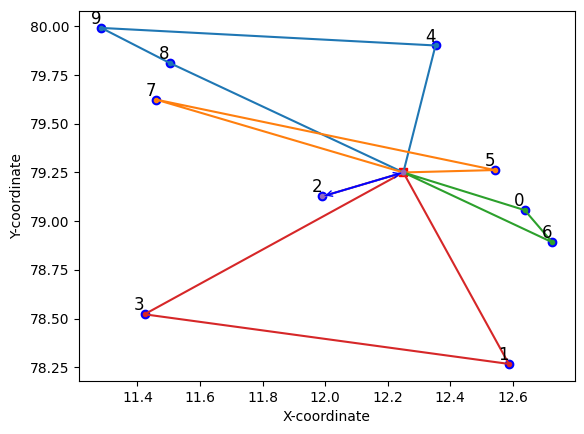

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_routes(routes, customer_locations):
    depot = (12.25, 79.25)
    plt.scatter(*depot, marker='s', color='red', label='Depot')
    # Plot customer locations
    for i, loc in enumerate(customer_locations):
        plt.scatter(*loc, marker='o', color='blue', label=f'Customer {i + 1}')
        plt.text(loc[0], loc[1], str(i), color='black', fontsize=12, ha='right', va='bottom')
    # Plot routes
    for r, route in enumerate(routes):
        route_points = [depot]  # Start from depot
        for customer in route:
            route_points.append(customer_locations[customer])
        route_points.append(depot)  # Return to depot
        route_x, route_y = zip(*route_points)
        plt.plot(route_x, route_y, marker='.', label=f'Route {r + 1}', linestyle='-')

    # Add arrows on the route line
    for i in range(len(route)+1):
        dx = route_points[i+1][0] - route_points[i][0]
        dy = route_points[i+1][1] - route_points[i][1]
        plt.annotate("", xy=route_points[i+1], xytext=route_points[i], arrowprops=dict(arrowstyle="->", color='blue'))

    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    #plt.figure(figsize=(8, 8))
    plt.show()
plot_routes(route_segments, node_locations)

## Model 2.1: Expected Value with scenario probabilities

### Code 1: 3 scenarios + probabilities + hard coded cost matrix

In [ ]:
from collections import defaultdict
import math
import random

def solve_svrp(num_customers, scenarios, demands, probabilities, vehicle_capacity, lower_bound, costs):
    def tsp_cost(route):
        cost = 0
        for i in range(len(route)):
            j = (i + 1) % len(route)
            cost += costs[(route[i], route[j], 1)]
        return cost

    def calculate_additional_cost(route, scenario):
        additional_cost = 0
        n = num_customers + 1
        remaining_capacity = vehicle_capacity
        total_delivery = defaultdict(int)

        for i in range(len(route)):
            j = (i + 1) % len(route)
            if route[j] == 0:  # Visiting the depot
                remaining_capacity = vehicle_capacity
                total_delivery.clear()
            else:
                demand = demands[scenario][route[j] - 1]
                if remaining_capacity >= demand:
                    remaining_capacity -= demand
                    total_delivery[route[j]] += demand
                else:
                    additional_cost += costs[(route[i], 0, 2)] + costs[(0, route[j], 2)]
                    remaining_capacity = vehicle_capacity - demand
                    total_delivery[route[j]] = demand

                if remaining_capacity < lower_bound:
                    additional_cost += costs[(route[j], 0, 2)] + costs[(0, route[(i + 2) % len(route)], 2)]
                    remaining_capacity = vehicle_capacity - total_delivery[route[(i + 2) % len(route)]]

        return additional_cost

    def permutations(iterable, r=None):
        pool = tuple(iterable)
        n = len(pool)
        r = n if r is None else r
        if r > n:
            return
        indices = list(range(n))
        cycles = list(range(n - r + 1, n + 1))[::-1]
        yield tuple(pool[i] for i in indices[:r])
        while n:
            for i in reversed(range(r)):
                cycles[i] -= 1
                if cycles[i] == 0:
                    indices[i:] = indices[i + 1:] + indices[i:i + 1]
                    cycles[i] = n - i
                else:
                    j = cycles[i]
                    indices[i], indices[-j] = indices[-j], indices[i]
                    yield tuple(pool[i] for i in indices[:r])
                    break
            else:
                return

    best_route = None
    min_cost = float('inf')

    # Generate all possible routes starting and ending at the depot
    for route in permutations(range(1, num_customers + 1), num_customers):
        route = (0,) + route + (0,)  # Add the depot to the start and end
        tsp_cost_value = tsp_cost(route)
        additional_cost_value = sum(probabilities[s] * calculate_additional_cost(route, s) for s in range(len(scenarios)))
        total_cost = tsp_cost_value + additional_cost_value

        if total_cost < min_cost:
            min_cost = total_cost
            best_route = route

    return min_cost, best_route

# Example usage
num_customers = 5
scenarios = [
    [10, 20, 15, 25, 30],
    [15, 25, 20, 30, 35],
    [20, 30, 25, 35, 40]
]
demands = scenarios  # Demands are the same as scenarios in this example
probabilities = [0.3, 0.4, 0.3]
vehicle_capacity = 100
lower_bound = 20

costs = {
    (0, 0, 1): 0, (0, 0, 2): 0,
    (0, 1, 1): 5, (1, 0, 1): 5, (0, 1, 2): 10, (1, 0, 2): 10,
    (0, 2, 1): 10, (2, 0, 1): 10, (0, 2, 2): 20, (2, 0, 2): 20,
    (0, 3, 1): 15, (3, 0, 1): 15, (0, 3, 2): 30, (3, 0, 2): 30,
    (0, 4, 1): 20, (4, 0, 1): 20, (0, 4, 2): 40, (4, 0, 2): 40,
    (0, 5, 1): 25, (5, 0, 1): 25, (0, 5, 2): 50, (5, 0, 2): 50,
    (1, 2, 1): 5, (2, 1, 1): 5, (1, 2, 2): 15, (2, 1, 2): 15,
    (1, 3, 1): 10, (3, 1, 1): 10, (1, 3, 2): 25, (3, 1, 2): 25,
    (1, 4, 1): 15, (4, 1, 1): 15, (1, 4, 2): 35, (4, 1, 2): 35,
    (1, 5, 1): 20, (5, 1, 1): 20, (1, 5, 2): 40, (5, 1, 2): 40,
    (2, 3, 1): 5, (3, 2, 1): 5, (2, 3, 2): 20, (3, 2, 2): 20,
    (2, 4, 1): 10, (4, 2, 1): 10, (2, 4, 2): 30, (4, 2, 2): 30,
    (2, 5, 1): 15, (5, 2, 1): 15, (2, 5, 2): 35, (5, 2, 2): 35,
    (3, 4, 1): 5, (4, 3, 1): 5, (3, 4, 2): 25, (4, 3, 2): 25,
    (3, 5, 1): 10, (5, 3, 1): 10, (3, 5, 2): 30, (5, 3, 2): 30,
    (4, 5, 1): 5, (5, 4, 1): 5, (4, 5, 2): 25, (5, 4, 2): 25
}


min_cost, best_route = solve_svrp(num_customers, scenarios, demands, probabilities, vehicle_capacity, lower_bound, costs)
print(f"Total cost: {min_cost}")
print(f"Best route: {best_route}")

Total cost: 94.0
Best route: (0, 4, 5, 3, 1, 2, 0)


### Code 2: Scenarios + Probabilities + distance based cost matrix

In [ ]:
import math
import random
from collections import defaultdict

def calculate_distance(coord_i, coord_j):
    x1, y1 = coord_i
    x2, y2 = coord_j
    ans = (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)*111/math.cos((x1+x2)/2)
    return ans

def solve_svrp_with_coordinates(num_customers, scenarios, demands, probabilities, vehicle_capacity, lower_bound, node_coordinates):
    def tsp_cost(route):
        cost = 0
        for i in range(len(route)):
            j = (i + 1) % len(route)
            cost += costs[(route[i], route[j], 1)]
        cost += costs[(route[-1], 0, 1)]
        return cost

    def calculate_additional_cost(route, scenario):
        additional_cost = 0
        n = num_customers + 1
        remaining_capacity = vehicle_capacity
        total_delivery = defaultdict(int)

        for i in range(len(route)):
            j = (i + 1) % len(route)
            if route[j] == 0:  # Visiting the depot
                remaining_capacity = vehicle_capacity
                total_delivery.clear()
            else:
                demand = demands[scenario][route[j] - 1]
                if remaining_capacity >= demand:
                    remaining_capacity -= demand
                    total_delivery[route[j]] += demand
                else:
                    additional_cost += costs[(route[i], 0, 2)] + costs[(0, route[j], 2)]
                    remaining_capacity = vehicle_capacity - demand
                    total_delivery[route[j]] = demand

                if remaining_capacity < lower_bound:
                    additional_cost += costs[(route[j], 0, 2)] + costs[(0, route[(i + 2) % len(route)], 2)]
                    remaining_capacity = vehicle_capacity - total_delivery[route[(i + 2) % len(route)]]

        return additional_cost

    def permutations(iterable, r=None):
        pool = tuple(iterable)
        n = len(pool)
        r = n if r is None else r
        if r > n:
            return
        indices = list(range(n))
        cycles = list(range(n - r + 1, n + 1))[::-1]
        yield tuple(pool[i] for i in indices[:r])
        while n:
            for i in reversed(range(r)):
                cycles[i] -= 1
                if cycles[i] == 0:
                    indices[i:] = indices[i + 1:] + indices[i:i + 1]
                    cycles[i] = n - i
                else:
                    j = cycles[i]
                    indices[i], indices[-j] = indices[-j], indices[i]
                    yield tuple(pool[i] for i in indices[:r])
                    break
            else:
                return

    best_route = None
    min_cost = float('inf')

    # Generate all possible routes starting and ending at the depot
    for route in permutations(range(1, num_customers + 1), num_customers):
        route = (0,) + route + (0,)  # Add the depot to the start and end

        tsp_cost_value = tsp_cost(route)
        additional_cost_value = sum(probabilities[s] * calculate_additional_cost(route, s) for s in range(len(scenarios)))
        total_cost = tsp_cost_value + additional_cost_value

        if total_cost < min_cost:
            min_cost = total_cost
            best_route = route
    return min_cost, best_route

# Example usage
num_customers = 5
scenarios = [
    [40, 50, 30, 20, 35],
    [38, 40, 20, 10, 30],
    [20, 30, 25, 25, 40],
    [10, 20, 30, 10, 20]
]
demands = scenarios  # Demands are the same as scenarios in this example
probabilities = [0.25, 0.25, 0.25, 0.25]
vehicle_capacity = 100
lower_bound = 20

node_coordinates = {
0: (11.99150079,	79.12719556), #Depot coordinates
1: (12.63770741,	79.05670822),
2: (12.58719656,	78.2674669),
3: (11.42275205,	78.52209754),
4: (12.35287935,	79.90159667),
5: (12.54238652,	79.26230753)
}
# Constructing the cost dictionary based on node coordinates
costs = {}
for i in node_coordinates:
    for j in node_coordinates:
        if i != j:
            costs[(i, j, 1)] = calculate_distance(node_coordinates[i], node_coordinates[j])
            costs[(i, j, 2)] = calculate_distance(node_coordinates[i], node_coordinates[j]) * 2  # Assuming double the distance for back-and-forth
# Adding costs for returning to the depot
costs[(0, 0, 1)] = 0
costs[(0, 0, 2)] = 0

min_cost, best_route = solve_svrp_with_coordinates(num_customers, scenarios, demands, probabilities, vehicle_capacity, lower_bound, node_coordinates)
print(f"Total cost: {min_cost}")
print(f"Best route: {best_route}")

Total cost: 928.5040513942918
Best route: (0, 3, 2, 1, 5, 4, 0)


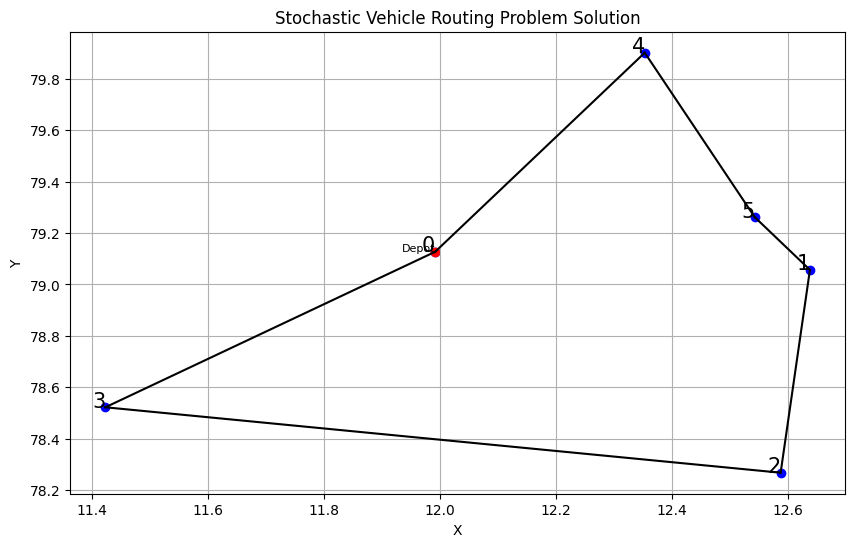

In [ ]:
import matplotlib.pyplot as plt

def plot_svrp_solution(node_coordinates, best_route):
    plt.figure(figsize=(10, 6))

    # Plotting nodes
    for i, (x, y) in node_coordinates.items():
        plt.scatter(x, y, color='blue')
        plt.text(x, y, f"{i}", fontsize=15, ha='right')

    # Plotting depot
    depot_x, depot_y = node_coordinates[0]
    plt.scatter(depot_x, depot_y, color='red')
    plt.text(depot_x, depot_y, "Depot", fontsize=8, ha='right')

    # Plotting routes
    for i in range(len(best_route)-1):
        start_node = best_route[i]
        #print(start_node)
        end_node = best_route[i + 1]
        #if start_node != 0:
        #if start_node:
        start_x, start_y = node_coordinates[start_node]
        end_x, end_y = node_coordinates[end_node]
        plt.plot([start_x, end_x], [start_y, end_y], color='black')

    plt.title('Stochastic Vehicle Routing Problem Solution')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

plot_svrp_solution(node_coordinates, best_route)

## Model 2.2: EV with node probabilities

### Code 1

In [ ]:
import numpy as np
from scipy.special import erf

# Parameters for the normal distribution (mean and standard deviation) for each node demand
node_parameters = {
    1: {'mean': 40, 'std_dev': 5},
    2: {'mean': 50, 'std_dev': 7},
    3: {'mean': 30, 'std_dev': 10},
    4: {'mean': 25, 'std_dev': 4},
    5: {'mean': 35, 'std_dev': 9}
}

# Generate demand scenarios and probabilities for each route
routes = [
    [1, 2, 3, 4, 5]
]

scenarios = []
probabilities = []

num_scenarios_per_route = 10000  # Adjust as needed

for route in routes:
    demand_scenario = {}
    route_probabilities = []

    # Generate demand scenarios for each node in the route
    for node in route:
        mean = node_parameters[node]['mean']
        std_dev = node_parameters[node]['std_dev']

        # Generate demand scenario for the node
        node_demand_scenarios = np.random.normal(mean, std_dev, num_scenarios_per_route)

        # Ensure demand is non-negative
        node_demand_scenarios = np.maximum(0, node_demand_scenarios)

        # Round demand values to nearest integer
        node_demand_scenarios = np.round(node_demand_scenarios).astype(int)

        # Store demand scenarios for the node
        demand_scenario[node] = node_demand_scenarios

        # Calculate probability for each demand scenario based on the cumulative distribution function (CDF)
        # Assuming a normal distribution, the probability of demand being less than or equal to a value x is given by the CDF at x
        cdf_probabilities = 0.5 * (1 + erf((node_demand_scenarios - mean) / (std_dev * np.sqrt(2))))
        node_probabilities = np.diff(np.concatenate(([0], cdf_probabilities)))  # Calculate differences to get probabilities

        # Ensure non-negativity of probabilities
        node_probabilities = np.maximum(0, node_probabilities)

        route_probabilities.append(node_probabilities)

    # Calculate joint probabilities for each scenario by multiplying probabilities of individual node demands
    route_probabilities = np.prod(np.array(route_probabilities), axis=0)

    # Normalize probabilities to sum to 1
    route_probabilities /= np.sum(route_probabilities)

    # Store route scenarios and probabilities
    scenarios.extend(list(zip(*[demand_scenario[node] for node in route])))
    probabilities.extend(route_probabilities)

# Convert to list of lists
scenarios = [list(t) for t in scenarios]
print("Scenarios:", scenarios)
print("Probabilities:", probabilities)

Scenarios: [[42, 61, 16, 14, 32], [39, 43, 32, 23, 31], [32, 60, 31, 23, 39], [35, 54, 19, 17, 30], [42, 28, 46, 23, 31], [37, 61, 38, 21, 42], [39, 49, 23, 27, 44], [48, 55, 34, 33, 28], [41, 53, 26, 27, 27], [38, 43, 46, 28, 53], [30, 61, 32, 23, 46], [43, 47, 29, 23, 22], [40, 56, 44, 27, 42], [28, 54, 18, 21, 23], [41, 42, 37, 31, 34], [40, 49, 23, 32, 36], [46, 61, 19, 32, 50], [41, 50, 28, 20, 37], [34, 37, 34, 21, 28], [39, 70, 36, 25, 23], [43, 51, 47, 27, 42], [34, 45, 39, 22, 46], [45, 47, 33, 18, 44], [46, 53, 24, 27, 41], [43, 36, 30, 29, 28], [40, 61, 42, 19, 29], [34, 39, 34, 24, 27], [42, 50, 47, 17, 48], [42, 37, 34, 26, 27], [42, 37, 21, 26, 31], [40, 56, 23, 25, 28], [43, 52, 31, 28, 40], [42, 55, 30, 28, 25], [33, 58, 50, 23, 50], [33, 39, 30, 19, 43], [37, 52, 19, 25, 52], [38, 56, 29, 26, 39], [37, 56, 22, 24, 49], [35, 46, 29, 28, 37], [44, 43, 37, 28, 23], [33, 65, 33, 27, 38], [36, 59, 30, 19, 31], [33, 53, 40, 21, 48], [36, 52, 40, 26, 41], [42, 44, 46, 27, 31]

In [ ]:
# Filter scenarios with non-zero probability
non_zero_scenarios = [scenario for scenario, probability in zip(scenarios, probabilities) if probability != 0]
non_zero_probabilities = [probability for probability in probabilities if probability != 0]

# Output the non-zero
print("Non-zero scenarios:", non_zero_scenarios)
print("Non-zero Probabilities:", non_zero_probabilities)
print(len(non_zero_scenarios))

Non-zero scenarios: [[42, 61, 16, 14, 32], [38, 50, 29, 29, 40], [43, 59, 41, 32, 39], [40, 52, 32, 30, 35], [40, 48, 36, 28, 36], [44, 38, 35, 27, 47], [51, 51, 47, 26, 36], [36, 55, 28, 31, 47], [42, 61, 28, 37, 36], [41, 54, 38, 19, 33], [40, 64, 42, 28, 43], [34, 54, 41, 26, 27], [43, 61, 19, 29, 40], [39, 62, 43, 25, 52], [39, 61, 41, 22, 38], [32, 57, 31, 23, 41], [39, 55, 31, 22, 32], [42, 50, 25, 28, 53], [45, 66, 35, 30, 42], [42, 54, 38, 32, 34], [38, 55, 42, 26, 37], [44, 50, 21, 29, 34], [36, 46, 38, 25, 29], [51, 52, 26, 23, 37], [42, 61, 26, 35, 40], [42, 57, 39, 32, 39], [43, 55, 36, 27, 40], [43, 57, 38, 29, 30], [37, 58, 36, 23, 60], [45, 53, 42, 25, 46], [40, 57, 46, 25, 42], [43, 59, 26, 24, 34], [37, 50, 16, 29, 43], [38, 54, 50, 35, 41], [43, 58, 40, 31, 32], [39, 64, 33, 27, 54], [41, 52, 47, 32, 30], [50, 65, 33, 21, 33], [39, 62, 44, 30, 41], [43, 59, 34, 30, 34], [40, 54, 33, 30, 44], [45, 51, 36, 30, 32], [37, 56, 31, 23, 50], [38, 50, 21, 31, 46], [40, 55, 15

In [ ]:
import math
import random
from collections import defaultdict
import numpy as np

def calculate_distance(coord_i, coord_j):
    x1, y1 = coord_i
    x2, y2 = coord_j
    ans = (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)*111/math.cos((x1+x2)/2)
    return ans

def solve_svrp_with_coordinates(num_customers, scenarios, demands, probabilities, vehicle_capacity, lower_bound, node_coordinates):
    def tsp_cost(route):
        cost = 0
        for i in range(len(route)):
            j = (i + 1) % len(route)
            cost += costs[(route[i], route[j], 1)]
        cost += costs[(route[-1], 0, 1)]
        return cost

    def calculate_additional_cost(route, scenario):
        additional_cost = 0
        n = num_customers + 1
        remaining_capacity = vehicle_capacity
        total_delivery = defaultdict(int)

        for i in range(len(route)):
            j = (i + 1) % len(route)
            if route[j] == 0:  # Visiting the depot
                remaining_capacity = vehicle_capacity
                total_delivery.clear()
            else:
                demand = demands[scenario][route[j] - 1]
                if remaining_capacity >= demand:
                    remaining_capacity -= demand
                    total_delivery[route[j]] += demand
                else:
                    additional_cost += costs[(route[i], 0, 2)] + costs[(0, route[j], 2)]
                    remaining_capacity = vehicle_capacity - demand
                    total_delivery[route[j]] = demand

                if remaining_capacity < lower_bound:
                    additional_cost += costs[(route[j], 0, 2)] + costs[(0, route[(i + 2) % len(route)], 2)]
                    remaining_capacity = vehicle_capacity - total_delivery[route[(i + 2) % len(route)]]

        return additional_cost

    def permutations(iterable, r=None):
        pool = tuple(iterable)
        n = len(pool)
        r = n if r is None else r
        if r > n:
            return
        indices = list(range(n))
        cycles = list(range(n - r + 1, n + 1))[::-1]
        yield tuple(pool[i] for i in indices[:r])
        while n:
            for i in reversed(range(r)):
                cycles[i] -= 1
                if cycles[i] == 0:
                    indices[i:] = indices[i + 1:] + indices[i:i + 1]
                    cycles[i] = n - i
                else:
                    j = cycles[i]
                    indices[i], indices[-j] = indices[-j], indices[i]
                    yield tuple(pool[i] for i in indices[:r])
                    break
            else:
                return

    best_route = None
    min_cost = float('inf')

    # Generate all possible routes starting and ending at the depot
    for route in permutations(range(1, num_customers + 1), num_customers):
        route = (0,) + route + (0,)  # Add the depot to the start and end
        tsp_cost_value = tsp_cost(route)
        additional_cost_value = sum(probabilities[s] * calculate_additional_cost(route, s) for s in range(len(scenarios)))
        total_cost = tsp_cost_value + additional_cost_value

        if total_cost < min_cost:
            min_cost = total_cost
            best_route = route
    return min_cost, best_route

# Example usage
num_customers = 5
vehicle_capacity = 100
lower_bound = 20
# scenarios and probabilities are taken from previous cell

demands = non_zero_scenarios
node_coordinates = {
0: (11.99150079,	79.12719556),
1: (12.63770741,	79.05670822),
2: (12.58719656,	78.2674669),
3: (11.42275205,	78.52209754),
4: (12.35287935,	79.90159667),
5: (12.54238652,	79.26230753)
}

# Constructing the cost dictionary based on node coordinates
costs = {}
for i in node_coordinates:
    for j in node_coordinates:
        if i != j:
            costs[(i, j, 1)] = calculate_distance(node_coordinates[i], node_coordinates[j])
            costs[(i, j, 2)] = calculate_distance(node_coordinates[i], node_coordinates[j]) * 2  # Assuming double the distance for back-and-forth
# Adding costs for returning to the depot
costs[(0, 0, 1)] = 0
costs[(0, 0, 2)] = 0

min_cost, best_route = solve_svrp_with_coordinates(num_customers, non_zero_scenarios, demands, non_zero_probabilities, vehicle_capacity, lower_bound, node_coordinates)
print(f"Total cost: {min_cost}")
print(f"Best route: {best_route}")

Total cost: 1411.0212989128268
Best route: (0, 3, 4, 5, 1, 2, 0)


In [ ]:
# Can be used if we consider equal probability for each scenario which does not make sense practically
import numpy as np

# Parameters for the normal distribution (mean and standard deviation) for each node demand
node_parameters = {
    1: {'mean': 20, 'std_dev': 5},
    2: {'mean': 25, 'std_dev': 7},
    # Add parameters for other nodes as needed
}

# Generate demand scenarios for each node
num_scenarios = 5 # Adjust as needed
scenarios = []
for _ in range(num_scenarios):
    demand_scenario = {}
    for node, params in node_parameters.items():
        mean = params['mean']
        std_dev = params['std_dev']

        # Generate demand value from the normal distribution
        demand_value = np.random.normal(mean, std_dev)

        # Ensure demand is non-negative
        demand_value = max(0, demand_value)

        # Round demand value to nearest integer
        demand_value = int(round(demand_value))

        demand_scenario[node] = demand_value

    scenarios.append(demand_scenario)

# Assign equal probabilities to each scenario
probabilities = [1 / num_scenarios] * num_scenarios

# Example usage:
print("Scenarios:")
for i, scenario in enumerate(scenarios):
    print(f"Scenario {i + 1}: {scenario}")
print("Probabilities:", probabilities)

Scenarios:
Scenario 1: {1: 23, 2: 37}
Scenario 2: {1: 17, 2: 28}
Scenario 3: {1: 16, 2: 31}
Scenario 4: {1: 21, 2: 27}
Scenario 5: {1: 15, 2: 27}
Probabilities: [0.2, 0.2, 0.2, 0.2, 0.2]


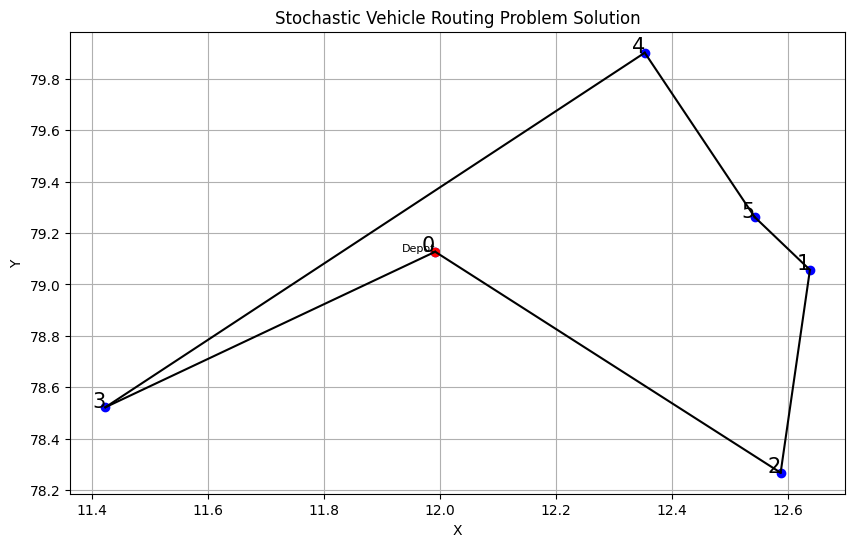

In [ ]:
import matplotlib.pyplot as plt

def plot_svrp_solution(node_coordinates, best_route):
    plt.figure(figsize=(10, 6))

    # Plotting nodes
    for i, (x, y) in node_coordinates.items():
        plt.scatter(x, y, color='blue')
        plt.text(x, y, f"{i}", fontsize=15, ha='right')

    # Plotting depot
    depot_x, depot_y = node_coordinates[0]
    plt.scatter(depot_x, depot_y, color='red')
    plt.text(depot_x, depot_y, "Depot", fontsize=8, ha='right')

    # Plotting routes
    for i in range(len(best_route)-1):
        start_node = best_route[i]
        #print(start_node)
        end_node = best_route[i + 1]
        #if start_node != 0:
        #if start_node:
        start_x, start_y = node_coordinates[start_node]
        end_x, end_y = node_coordinates[end_node]
        plt.plot([start_x, end_x], [start_y, end_y], color='black')

    plt.title('Stochastic Vehicle Routing Problem Solution')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

plot_svrp_solution(node_coordinates, best_route)

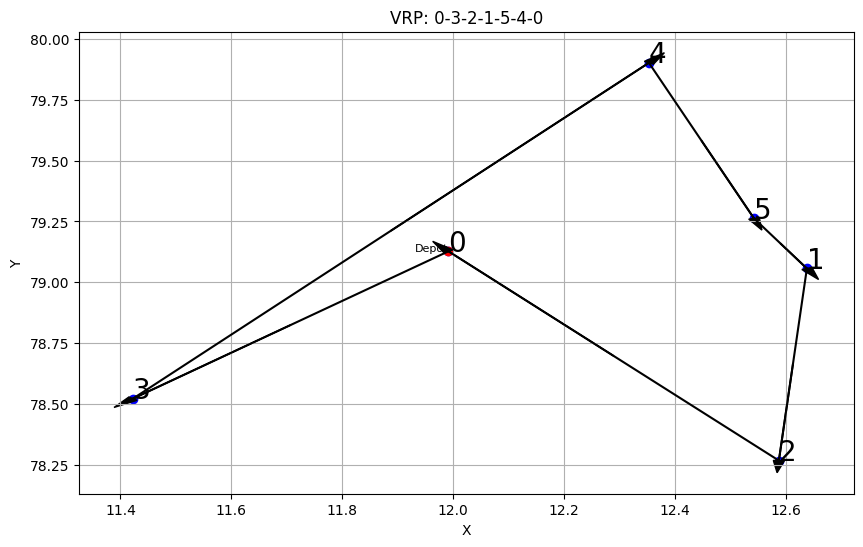

In [ ]:
import matplotlib.pyplot as plt

def plot_svrp_solution(node_coordinates, best_route):
    plt.figure(figsize=(10, 6))

    # Plotting nodes
    for i, (x, y) in node_coordinates.items():
        plt.scatter(x, y, color='blue')
        plt.text(x, y, f"{i}", fontsize=20, ha='left')

    # Plotting depot
    depot_x, depot_y = node_coordinates[0]
    plt.scatter(depot_x, depot_y, color='red')
    plt.text(depot_x, depot_y, "Depot", fontsize=8, ha='right')

    # Plotting routes with arrows
    for i in range(len(best_route)-1):
        start_node = best_route[i]
        end_node = best_route[i + 1]
        start_x, start_y = node_coordinates[start_node]
        end_x, end_y = node_coordinates[end_node]

        # Calculating midpoint
        mid_x = (start_x + end_x) / 2
        mid_y = (start_y + end_y) / 2

        # Plotting route
        plt.plot([start_x, end_x], [start_y, end_y], color='black')

        # Plotting arrow at midpoint
        dx = mid_x - start_x
        dy = mid_y - start_y
        plt.arrow(mid_x, mid_y, dx, dy, head_width=0.02, head_length=0.05, fc='black', ec='black')

    plt.title('VRP: 0-3-2-1-5-4-0')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

plot_svrp_solution(node_coordinates, best_route)

## VRP route considering expected value demands

In [ ]:
import math
import random
from collections import defaultdict
import numpy as np

def calculate_distance(coord_i, coord_j):
    x1, y1 = coord_i
    x2, y2 = coord_j
    ans = (((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)*111/math.cos((x1+x2)/2)
    return ans

def solve_svrp_with_coordinates_tsp(num_customers, vehicle_capacity, node_coordinates):
    def tsp_cost(route):
        cost = 0
        for i in range(len(route)):
            j = (i + 1) % len(route)
            cost += costs_tsp[(route[i], route[j], 1)]
        cost += costs_tsp[(route[-1], 0, 1)]
        return cost

    def permutations(iterable, r=None):
        pool = tuple(iterable)
        n = len(pool)
        r = n if r is None else r
        if r > n:
            return
        indices = list(range(n))
        cycles = list(range(n - r + 1, n + 1))[::-1]
        yield tuple(pool[i] for i in indices[:r])
        while n:
            for i in reversed(range(r)):
                cycles[i] -= 1
                if cycles[i] == 0:
                    indices[i:] = indices[i + 1:] + indices[i:i + 1]
                    cycles[i] = n - i
                else:
                    j = cycles[i]
                    indices[i], indices[-j] = indices[-j], indices[i]
                    yield tuple(pool[i] for i in indices[:r])
                    break
            else:
                return

    best_route_tsp = None
    min_cost_tsp = float('inf')

    # Generate all possible routes starting and ending at the depot
    for route in permutations(range(1, num_customers + 1), num_customers):
        route = (0,) + route + (0,)  # Add the depot to the start and end
        tsp_cost_value = tsp_cost(route)
        total_cost = tsp_cost_value

        if total_cost < min_cost_tsp:
            min_cost_tsp = total_cost
            best_route_tsp = route
    return min_cost_tsp, best_route_tsp

# Example usage
num_customers = 5
vehicle_capacity = 100
#lower_bound = 20
#demands = non_zero_scenarios
# Sum of mean demands from each node <= vehicle capacity
node_coordinates = {
0: (11.99150079,	79.12719556),
1: (12.63770741,	79.05670822),
2: (12.58719656,	78.2674669),
3: (11.42275205,	78.52209754),
4: (12.35287935,	79.90159667),
5: (12.54238652,	79.26230753)
}
# Constructing the cost dictionary based on node coordinates
costs_tsp = {}
for i in node_coordinates:
    for j in node_coordinates:
        if i != j:
            costs_tsp[(i, j, 1)] = calculate_distance(node_coordinates[i], node_coordinates[j])
            costs_tsp[(i, j, 2)] = calculate_distance(node_coordinates[i], node_coordinates[j]) * 2  # Assuming double the distance for back-and-forth
# Adding costs for returning to the depot
costs_tsp[(0, 0, 1)] = 0
costs_tsp[(0, 0, 2)] = 0

min_cost_tsp, best_route_tsp = solve_svrp_with_coordinates_tsp(num_customers, vehicle_capacity, node_coordinates)
#min_cost_tsp, best_route_tsp = solve_svrp_with_coordinates_tsp(num_customers, non_zero_scenarios, demands, vehicle_capacity, lower_bound, node_coordinates)


print(f"Total cost: {min_cost_tsp}")
print(f"Best route: {best_route_tsp}")

Total cost: 587.7702799952117
Best route: (0, 3, 2, 1, 5, 4, 0)


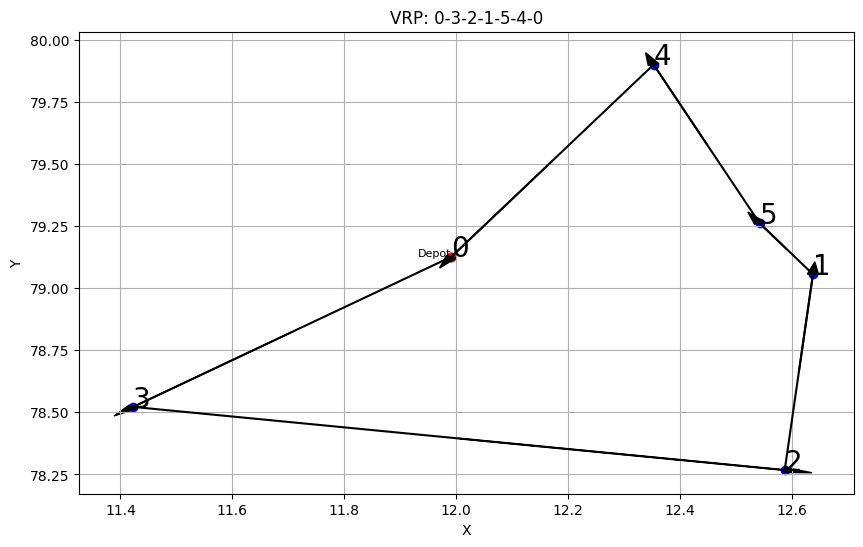

In [ ]:
plot_svrp_solution(node_coordinates, best_route_tsp)

## Comparing the cost saved in SVRP route vs. VRP route

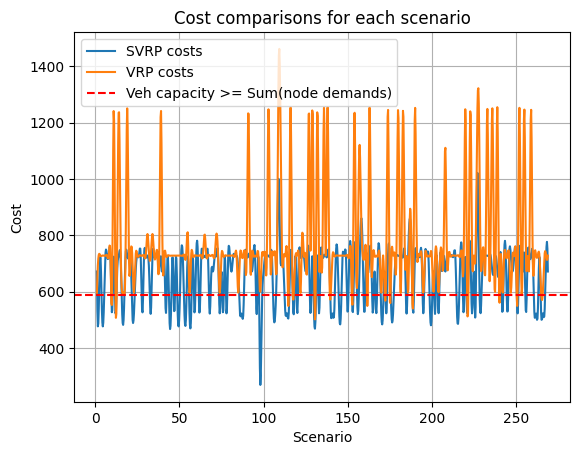

In [ ]:
import matplotlib.pyplot as plt

# Function to calculate cost for each scenario using the best route
def calculate_scenario_costs(best_route, scenarios, demands, vehicle_capacity, lower_bound, node_coordinates):
    scenario_costs = []
    for scenario in range(len(scenarios)):
        additional_cost_value = calculate_additional_cost(best_route, scenario, demands, vehicle_capacity, lower_bound)
        scenario_costs.append(additional_cost_value)
    return scenario_costs

# Function to calculate additional cost for a scenario using the best route
def calculate_additional_cost(route, scenario, demands, vehicle_capacity, lower_bound):
    additional_cost = 0
    n = num_customers + 1
    remaining_capacity = vehicle_capacity
    total_delivery = defaultdict(int)

    for i in range(len(route)):
        j = (i + 1) % len(route)
        if route[j] == 0:  # Visiting the depot
            remaining_capacity = vehicle_capacity
            total_delivery.clear()
        else:
            demand = demands[scenario][route[j] - 1]
            if remaining_capacity >= demand:
                remaining_capacity -= demand
                total_delivery[route[j]] += demand
            else:
                additional_cost += costs[(route[i], 0, 2)] + costs[(0, route[j], 2)]
                remaining_capacity = vehicle_capacity - demand
                total_delivery[route[j]] = demand

            if remaining_capacity < lower_bound:
                additional_cost += costs[(route[j], 0, 2)] + costs[(0, route[(i + 2) % len(route)], 2)]
                remaining_capacity = vehicle_capacity - total_delivery[route[(i + 2) % len(route)]]

    return additional_cost

# Calculate scenario costs using the best route
scenario_costs_svrp = calculate_scenario_costs(best_route, non_zero_scenarios, demands, vehicle_capacity, lower_bound, node_coordinates)
scenario_costs_vrp = calculate_scenario_costs(best_route_tsp, non_zero_scenarios, demands, vehicle_capacity, lower_bound, node_coordinates)

import numpy as np
from scipy.interpolate import make_interp_spline

# Generate a smoother curve
x_smooth_svrp = np.linspace(1, len(scenario_costs_svrp), 1000)  # 300 represents number of points to make between T.min and T.max
y_smooth_svrp = make_interp_spline(range(1, len(scenario_costs_svrp)+1), scenario_costs_svrp)(x_smooth_svrp)

x_smooth_vrp = np.linspace(1, len(scenario_costs_vrp), 1000)  # 300 represents number of points to make between T.min and T.max
y_smooth_vrp = make_interp_spline(range(1, len(scenario_costs_vrp)+1), scenario_costs_vrp)(x_smooth_vrp)

# Plot the smoother curve
plt.plot(x_smooth_svrp, y_smooth_svrp, label='SVRP costs')
plt.plot(x_smooth_vrp, y_smooth_vrp, label='VRP costs')
plt.xlabel('Scenario')
plt.ylabel('Cost')
plt.title('Cost comparisons for each scenario')
plt.grid(True)
#plt.show()

# Plot horizontal line for min_cost_tsp
plt.axhline(y=min_cost_tsp, color='r', linestyle='--', label='Veh capacity >= Sum(node demands)')

plt.legend()
plt.show()

In [ ]:
# Calculate the percentage of scenarios where SVRP costs < VRP costs
num_scenarios = len(scenario_costs_svrp)
print(num_scenarios)
num_svrp_less_than_vrp = sum(svrp == vrp for svrp, vrp in zip(scenario_costs_svrp, scenario_costs_vrp))
print(num_svrp_less_than_vrp)
percentage_svrp_less_than_vrp = (num_svrp_less_than_vrp / num_scenarios) * 100

print(f"Percentage of scenarios where SVRP costs are less than VRP costs: {percentage_svrp_less_than_vrp}%")

250
119
Percentage of scenarios where SVRP costs are less than VRP costs: 47.599999999999994%
